# Analyse Exploratoire

### Import des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import numpy as np

### Analyse Exploratoire

In [2]:
building_consumption = pd.read_csv("building_energy_benchmarking.csv")

In [3]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
building_consumption.shape

(3376, 46)

## Préparation du DF de travail

#### Inspection du DF de base

In [5]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [6]:
building_consumption["DataYear"].nunique()


1

In [7]:
building_consumption["City"].nunique()

1

In [8]:
building_consumption["State"].nunique()

1

In [9]:
building_consumption["Comments"].nunique()

0

In [10]:
building_consumption["CouncilDistrictCode"].nunique()

7

In [11]:
building_consumption["ZipCode"].nunique()

55

In [12]:
building_consumption_clean = building_consumption.copy()

On peut supprimer les colonnes **DataYear**, **City**, **State** car elles ont toutes la même valeur. et **Comments** car il n'a pas de valeur.

In [13]:
building_consumption_clean = building_consumption_clean.drop(["DataYear", "City", "State", "Comments"], axis=1)


In [14]:
building_consumption_clean = building_consumption_clean.drop(["Latitude", "Longitude"], axis=1)

In [15]:
building_consumption["Neighborhood"].value_counts()

Neighborhood
DOWNTOWN                  573
EAST                      453
MAGNOLIA / QUEEN ANNE     423
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                251
NORTHWEST                 210
SOUTHWEST                 166
NORTH                     145
BALLARD                   126
CENTRAL                   107
SOUTHEAST                  95
DELRIDGE                   80
North                      42
Central                    27
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

On peut également supprimer l'**adresse**, le **ZipCode**, le **TaxParcelIdentificationNumber** et **CouncilDistrictCode** car on a le voisinage.

In [16]:
building_consumption_clean["Neighborhood"] = (
    building_consumption_clean["Neighborhood"].replace({
        'Central': 'CENTRAL',
        'North': 'NORTH',
        'Northwest': 'NORTHWEST',
        'Ballard': 'BALLARD',
        'Delridge': 'DELRIDGE',
        'DELRIDGE NEIGHBOHORDOODS': 'DELRIDGE'
    })
)


In [17]:
building_consumption_clean = building_consumption_clean.drop(["Address", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode"], axis=1)


In [18]:
building_consumption["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [19]:
building_consumption_clean = building_consumption_clean[
    building_consumption_clean["BuildingType"].isin(["NonResidential","Nonresidential COS"])
]

#### Comparer les unités d'énergies

In [20]:
building_consumption_clean[
    ((building_consumption_clean["NaturalGas(therms)"].isna()) | 
     (building_consumption_clean["NaturalGas(therms)"] == 0)) &
    ((building_consumption_clean["NaturalGas(kBtu)"].notna()) & 
     (building_consumption_clean["NaturalGas(kBtu)"] != 0))
][["BuildingType", "NaturalGas(therms)","NaturalGas(kBtu)"]]

,BuildingType,NaturalGas(therms),NaturalGas(kBtu)


In [21]:
building_consumption_clean[
    ((building_consumption_clean["Electricity(kWh)"].isna()) | 
     (building_consumption_clean["Electricity(kWh)"] == 0)) &
    ((building_consumption_clean["Electricity(kBtu)"].notna()) & 
     (building_consumption_clean["Electricity(kBtu)"] != 0))
][["BuildingType", "Electricity(kWh)", "Electricity(kBtu)"]]

,BuildingType,Electricity(kWh),Electricity(kBtu)


Toutes les colonnes ayant des valeurs en therms ou en kWh on leur équivalent en kBtu. On va donc supprimer ces colonnes.

In [22]:
building_consumption_clean = building_consumption_clean.drop(["Electricity(kWh)", "NaturalGas(therms)"], axis=1)

In [23]:
building_consumption_clean.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [24]:
building_consumption_clean.shape

(1545, 34)

#### Données diverses

In [25]:
building_consumption_clean["YearsENERGYSTARCertified"].value_counts()

YearsENERGYSTARCertified
2016                                5
2017                                5
20162015                            4
2009                                4
2013                                4
                                   ..
20172015201420132011                1
20152012                            1
201620152014                        1
20162015201420132012201020092008    1
20162015201020092008                1
Name: count, Length: 64, dtype: int64

In [26]:
building_consumption_clean["YearsENERGYSTARCertified"] = (
    building_consumption_clean["YearsENERGYSTARCertified"]
    .astype(str)
    .apply(lambda x: re.findall(r"\d{4}", x)[0] if re.findall(r"\d{4}", x) else None)
)

In [27]:
building_consumption_clean["YearsENERGYSTARCertified"].value_counts()

YearsENERGYSTARCertified
2016    33
2017    27
2009     6
2014     5
2015     5
2010     4
2013     4
2012     3
2011     3
2007     1
Name: count, dtype: int64

#### DefaultData

**DefaultData** : Données estimées ou réelles

In [28]:
building_consumption_clean["DefaultData"].value_counts()

DefaultData
False    1532
True       13
Name: count, dtype: int64

C'est ce qu'on suppose qu'on devrait avoir comme données. False = c'est bon, corrigée au données réelles.

#### Compliance Status

**ComplianceStatus** : Conformité réglementaire du bâtiment

In [29]:
building_consumption_clean["ComplianceStatus"].value_counts()


ComplianceStatus
Compliant                       1513
Non-Compliant                     18
Error - Correct Default Data      13
Missing Data                       1
Name: count, dtype: int64

In [30]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Error - Correct Default Data"]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
276,405,NonResidential,Large Office,The Decatur,DOWNTOWN,1921,1.0,4,127268,0,...,7.711758e+06,7.711758e+06,714523.6875,6.039805e+06,957428.0000,True,Error - Correct Default Data,NaN,148.11,1.16
457,618,NonResidential,Small- and Mid-Sized Office,Prefontaine,DOWNTOWN,1909,1.0,6,73470,0,...,3.212269e+06,3.408134e+06,0.0000,3.212269e+06,0.0000,True,Error - Correct Default Data,NaN,22.39,0.30
1045,20617,NonResidential,Retail Store,Seattle Habitat Store,GREATER DUWAMISH,1953,1.0,1,39900,0,...,1.454688e+05,1.454688e+05,0.0000,4.900500e+04,96464.0000,True,Error - Correct Default Data,Low outlier,5.46,0.14
1466,21898,NonResidential,Warehouse,Halfon Candy Company,GREATER DUWAMISH,1978,1.0,1,31300,0,...,3.628740e+05,3.984386e+05,0.0000,2.209130e+05,141961.0000,True,Error - Correct Default Data,NaN,9.08,0.29
1467,21902,NonResidential,Warehouse,Samson,GREATER DUWAMISH,1979,1.0,1,22000,0,...,7.006276e+05,7.006276e+05,0.0000,7.006280e+05,0.0000,True,Error - Correct Default Data,NaN,4.88,0.22
1641,22953,NonResidential,Retail Store,Tux Shop,NORTH,1965,1.0,1,24982,0,...,3.352450e+05,3.352450e+05,0.0000,3.352450e+05,0.0000,True,Error - Correct Default Data,NaN,2.34,0.09
1656,23011,NonResidential,Retail Store,Bevmo,NORTH,1966,1.0,1,41615,0,...,1.900006e+06,2.001297e+06,0.0000,1.900006e+06,0.0000,True,Error - Correct Default Data,NaN,13.25,0.32
1977,24030,NonResidential,Retail Store,King Plaza 6951,GREATER DUWAMISH,2002,1.0,2,54211,17471,...,1.267463e+06,1.267463e+06,0.0000,1.267463e+06,0.0000,True,Error - Correct Default Data,NaN,8.84,0.16
2076,24374,NonResidential,Retail Store,Jumbo chinese restaurant,SOUTHEAST,1968,1.0,1,36071,0,...,1.519952e+06,1.519952e+06,0.0000,6.493550e+05,870597.0000,True,Error - Correct Default Data,NaN,50.76,1.41
2682,26593,NonResidential,Small- and Mid-Sized Office,Delmar Building,DOWNTOWN,1900,1.0,4,22840,0,...,8.813862e+05,9.830534e+05,0.0000,8.813860e+05,0.0000,True,Error - Correct Default Data,NaN,6.14,0.27


Ces bâtiment ont beaucoup de données. On va donc les garder.

In [31]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Missing Data"]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
746,19776,NonResidential,Other,Welcome Home Society - PriceCo,NORTHWEST,2002,1.0,1,29924,0,...,0.0,0.0,0.0,0.0,0.0,False,Missing Data,NaN,0.0,0.0


On peut supprimer ces lignes qui ont trop de valeurs manquantes.

In [32]:
building_consumption_clean = building_consumption_clean.drop([746], axis=0)

In [33]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Non-Compliant"]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,NonResidential,Large Office,Second And Spring Building,DOWNTOWN,1958,1.0,6,172842,25920,...,4.139950e+07,4.165040e+07,0.0,39794668.0,1604831.0,False,Non-Compliant,High outlier,362.66,2.10
304,435,NonResidential,Other,Washington State Convention Center,DOWNTOWN,1990,1.0,6,1400000,0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,False,Non-Compliant,NaN,0.00,0.00
384,539,NonResidential,Retail Store,University Center,NORTHEAST,1987,1.0,2,69492,0,...,3.189628e+05,3.189628e+05,0.0,318963.0,0.0,False,Non-Compliant,Low outlier,2.22,0.03
448,608,NonResidential,Large Office,411 1ST AVE S (ID608),DOWNTOWN,1913,5.0,7,154159,0,...,1.119592e+07,1.134876e+07,0.0,1608768.0,343050.0,False,Non-Compliant,Low outlier,29.43,0.19
517,704,NonResidential,Large Office,401 Elliott Ave West,MAGNOLIA / QUEEN ANNE,2000,1.0,4,129551,42500,...,2.713719e+07,2.713719e+07,0.0,27137187.0,0.0,False,Non-Compliant,High outlier,189.18,1.46
578,773,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,DOWNTOWN,1924,NaN,4,63150,0,...,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
1229,21315,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,DOWNTOWN,1903,1.0,3,57720,0,...,2.410550e+04,2.410550e+04,0.0,24105.0,0.0,False,Non-Compliant,Low outlier,0.17,0.00
1295,21474,NonResidential,Other,The Lusty Lady,DOWNTOWN,1900,1.0,3,49760,0,...,4.429350e+04,4.429350e+04,0.0,44294.0,0.0,False,Non-Compliant,Low outlier,0.31,0.01
1611,22830,NonResidential,Worship Facility,Freedom Church,SOUTHWEST,1971,1.0,1,23772,0,...,1.008417e+05,1.008417e+05,0.0,100842.0,0.0,False,Non-Compliant,Low outlier,0.70,0.03
1945,23912,NonResidential,Small- and Mid-Sized Office,1416 S Jackson,CENTRAL,1947,1.0,1,45068,0,...,2.848573e+05,3.092140e+05,0.0,141784.0,143073.0,False,Non-Compliant,Low outlier,8.59,0.19


#### Outlier

Outlier : Valeurs extrêmes identifiées

In [34]:
building_consumption_clean["Outlier"].value_counts()

Outlier
Low outlier     14
High outlier     2
Name: count, dtype: int64

In [35]:
building_consumption_clean[
    building_consumption_clean["Outlier"].isin(["Low outlier"])
]["ListOfAllPropertyUseTypes"]

384                                 Retail Store
448                                       Office
1045    Non-Refrigerated Warehouse, Retail Store
1229                                      Office
1295                                       Other
1611                            Worship Facility
1945                                      Office
2129                                 K-12 School
2189                              Other, Parking
2216                             Office, Parking
2410                                       Hotel
2450          Bar/Nightclub, Multifamily Housing
2801                            Worship Facility
3152                                       Other
Name: ListOfAllPropertyUseTypes, dtype: object

In [36]:
building_consumption_clean[
    building_consumption_clean["Outlier"].isin(["High outlier"])
]["ListOfAllPropertyUseTypes"]

226    Data Center, Office, Parking
517    Data Center, Office, Parking
Name: ListOfAllPropertyUseTypes, dtype: object

Il est normal que les valeurs de Outlier soit High car ce sont des Data Center

#### Données mise à jour avec la météo

Comparer si les données qui prennent en compte la météo sont disponibles pour tous les bâtiments

In [37]:
building_consumption_clean[
    (building_consumption_clean["SiteEUIWN(kBtu/sf)"].isna() | 
     (building_consumption_clean["SiteEUIWN(kBtu/sf)"] == 0))
][["BuildingType", "SiteEUIWN(kBtu/sf)", "SiteEUI(kBtu/sf)"]]


,BuildingType,SiteEUIWN(kBtu/sf),SiteEUI(kBtu/sf)
220,NonResidential,0.0,105.199997
247,NonResidential,0.0,73.000000
284,NonResidential,0.0,43.400002
304,NonResidential,0.0,NaN
350,NonResidential,0.0,50.000000
563,NonResidential,NaN,39.500000
578,NonResidential,NaN,NaN
882,NonResidential,0.0,20.700001
953,NonResidential,0.0,37.599998
2670,NonResidential,NaN,NaN


Nous avons quelques valeurs qui ne tiennent pas en compte les valeurs de la météo mais contiennent des valeurs qui n'en tiennent pas compte. On va donc garder ces deux colonnes.

In [38]:
building_consumption_clean.loc[[304, 578, 2670]]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
304,435,NonResidential,Other,Washington State Convention Center,DOWNTOWN,1990,1.0,6,1400000,0,...,0.0,0.0,0.0,0.0,0.0,False,Non-Compliant,NaN,0.0,0.0
578,773,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,DOWNTOWN,1924,NaN,4,63150,0,...,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN
2670,26532,NonResidential,Mixed Use Property,KALBERG BUILDING,NORTHEAST,1928,NaN,2,20760,0,...,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN,NaN


In [39]:
building_consumption_clean = building_consumption_clean.drop([304, 578, 2670], axis=0)

In [40]:
building_consumption_clean["SiteEUI(kBtu/sf)"].min()

np.float64(0.699999988)

Regardons plus en détail les lignes qui ont 0 & Nan

In [41]:
building_consumption_clean.loc[building_consumption_clean["SiteEUI(kBtu/sf)"].idxmin()]

OSEBuildingID                                         24717
BuildingType                                 NonResidential
PrimaryPropertyType                                   Other
PropertyName                       1701 First Ave South LLC
Neighborhood                               GREATER DUWAMISH
YearBuilt                                              1910
NumberofBuildings                                       1.0
NumberofFloors                                            3
PropertyGFATotal                                      27690
PropertyGFAParking                                        0
PropertyGFABuilding(s)                                27690
ListOfAllPropertyUseTypes                    Other, Parking
LargestPropertyUseType                                Other
LargestPropertyUseTypeGFA                           24717.0
SecondLargestPropertyUseType                        Parking
SecondLargestPropertyUseTypeGFA                         0.0
ThirdLargestPropertyUseType             

In [42]:
building_consumption_clean["SiteEUI(kBtu/sf)"].mean()

np.float64(74.27027911595782)

In [43]:
building_consumption_clean["SiteEUI(kBtu/sf)"].max()

np.float64(834.4000244)

In [44]:
building_consumption_clean["SiteEUIWN(kBtu/sf)"].min()

np.float64(0.0)

In [45]:
building_consumption_clean.loc[building_consumption_clean["SiteEUI(kBtu/sf)"].idxmax()]

OSEBuildingID                                       365
BuildingType                             NonResidential
PrimaryPropertyType                               Other
PropertyName                       UW Tower Data Center
Neighborhood                                  NORTHEAST
YearBuilt                                          1969
NumberofBuildings                                   1.0
NumberofFloors                                        5
PropertyGFATotal                                  36000
PropertyGFAParking                                    0
PropertyGFABuilding(s)                            36000
ListOfAllPropertyUseTypes                   Data Center
LargestPropertyUseType                      Data Center
LargestPropertyUseTypeGFA                       36000.0
SecondLargestPropertyUseType                        NaN
SecondLargestPropertyUseTypeGFA                     NaN
ThirdLargestPropertyUseType                         NaN
ThirdLargestPropertyUseTypeGFA                  

Ok pour le max, c'est un DataCenter


In [46]:
building_consumption_clean.loc[building_consumption_clean["SiteEUIWN(kBtu/sf)"].idxmin()]


OSEBuildingID                                  343
BuildingType                        NonResidential
PrimaryPropertyType                   Large Office
PropertyName                       Norton Building
Neighborhood                              DOWNTOWN
YearBuilt                                     1958
NumberofBuildings                              1.0
NumberofFloors                                  17
PropertyGFATotal                            378525
PropertyGFAParking                           84600
PropertyGFABuilding(s)                      293925
ListOfAllPropertyUseTypes          Office, Parking
LargestPropertyUseType                      Office
LargestPropertyUseTypeGFA                 236827.0
SecondLargestPropertyUseType               Parking
SecondLargestPropertyUseTypeGFA            83311.0
ThirdLargestPropertyUseType             Restaurant
ThirdLargestPropertyUseTypeGFA             14679.0
YearsENERGYSTARCertified                      None
ENERGYSTARScore                

In [47]:
building_consumption_clean.shape

(1541, 34)

#### Valeurs vides

In [48]:
cols_to_check = [
    "SiteEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)"
]


Vérifiez qu'il existe ou nous des lignes où toutes les valeurs sont égales à 0 ou NaN

In [49]:
building_consumption_clean[
    building_consumption_clean[cols_to_check].isna().all(axis=1) |   
    (building_consumption_clean[cols_to_check] == 0).all(axis=1)   
]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


#### Matrice de corrélation de Pearson

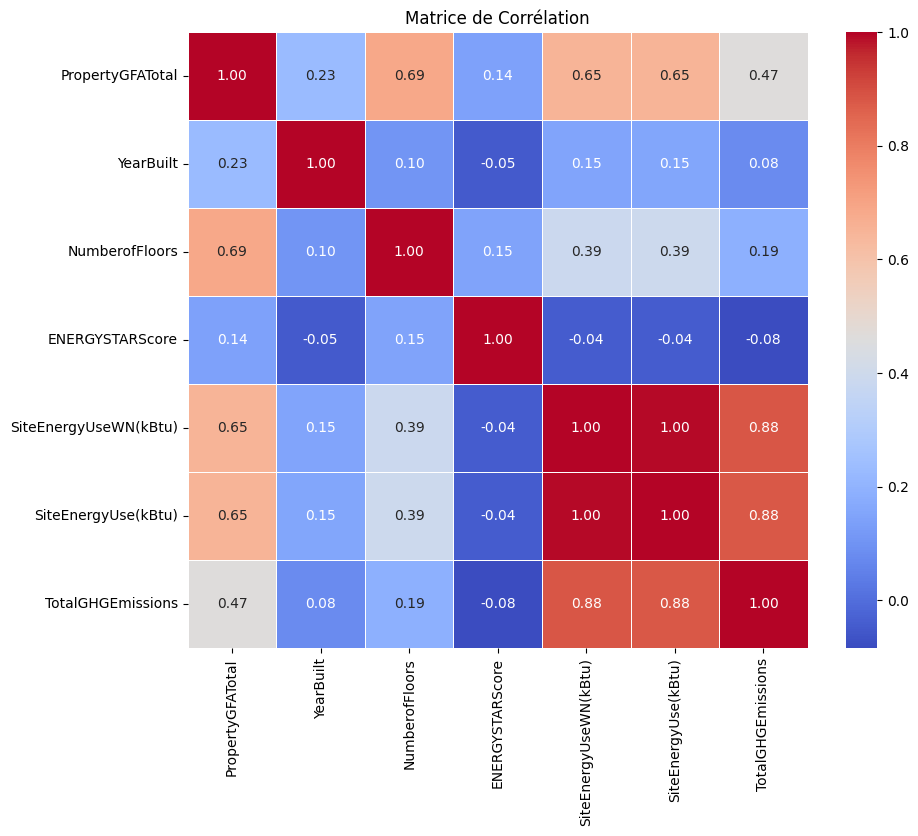

In [50]:
colonnes_correlation = [
    'PropertyGFATotal', 
    'YearBuilt', 
    'NumberofFloors',
    'ENERGYSTARScore', 
    'SiteEnergyUseWN(kBtu)', 
    'SiteEnergyUse(kBtu)', 
    'TotalGHGEmissions'
]

df_corr = building_consumption_clean[colonnes_correlation].copy()

# 2. Calcul de la matrice de corrélation
matrice_corr = df_corr.corr(method='pearson')

# 3. Visualisation (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
)
plt.title('Matrice de Corrélation')
plt.show()

#### Consommation énergétique en fonction du voisinage

In [51]:
building_consumption_clean.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

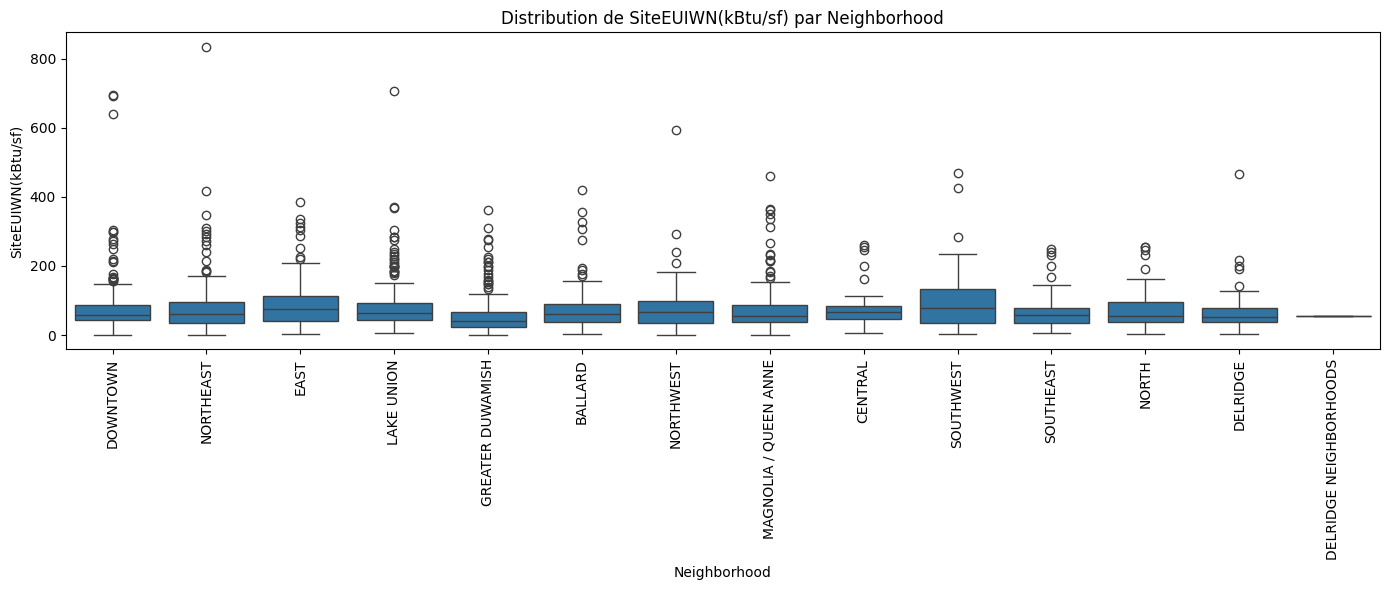

In [52]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=building_consumption_clean,
    x="Neighborhood",
    y="SiteEUIWN(kBtu/sf)"
)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEUIWN(kBtu/sf) par Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

#### Lien entre l'année de construction et la consommation énergétique

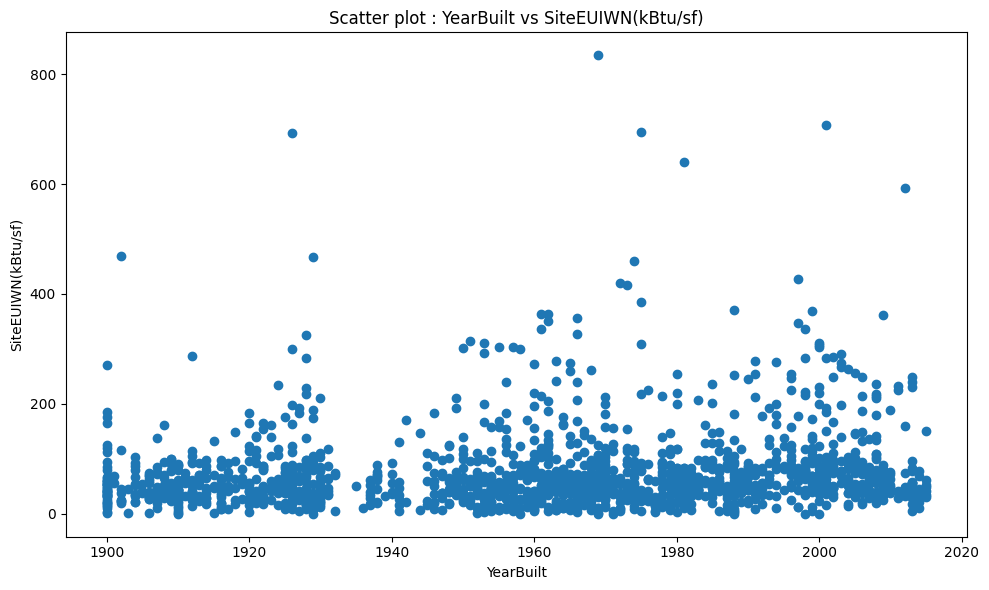

In [53]:

df = building_consumption_clean.copy()

plt.figure(figsize=(10,6))
plt.scatter(df["YearBuilt"], df["SiteEUIWN(kBtu/sf)"])

plt.xlabel("YearBuilt")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.title("Scatter plot : YearBuilt vs SiteEUIWN(kBtu/sf)" )

plt.tight_layout()
plt.show()

**Outliers?**

#### Lien entre la consommation énergétique & celle mise à jour via la météo

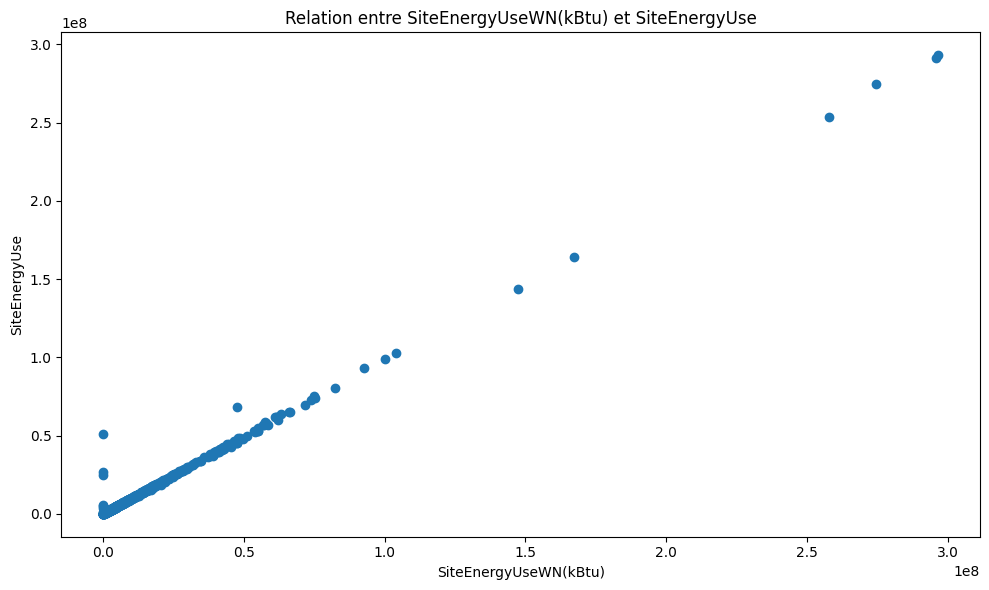

In [54]:

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu)"], df["SiteEnergyUse(kBtu)"])

plt.xlabel("SiteEnergyUseWN(kBtu)")
plt.ylabel("SiteEnergyUse")
plt.title("Relation entre SiteEnergyUseWN(kBtu) et SiteEnergyUse")

plt.tight_layout()
plt.show()

Au vu de la courbe, on peut déduire qu'il y a un ratio entre SiteEnergyUse et SiteEnergyUseWN

Regardez valeur proche de 0 & clean

In [55]:
df = building_consumption_clean.copy()

clean_df = df[["SiteEnergyUseWN(kBtu)", "SiteEnergyUse(kBtu)"]].copy()

clean_df["SiteEnergyUseWN(kBtu)"].replace(0, np.nan, inplace=True)

clean_df["ratio"] = clean_df["SiteEnergyUse(kBtu)"] / clean_df["SiteEnergyUseWN(kBtu)"]

clean_df = clean_df.dropna(subset=["ratio"])

mean_ratio = clean_df["ratio"].mean()
mean_ratio

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\3185432864.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df["SiteEnergyUseWN(kBtu)"].replace(0, np.nan, inplace=True)


np.float64(0.9539660875649302)

In [56]:
ratio = 0.95

**Mise à jour du DF avec ce ratio pour remplir toutes les lignes**

In [57]:
building_consumption_clean.loc[
    (building_consumption_clean["SiteEnergyUse(kBtu)"].isna() | (building_consumption_clean["SiteEnergyUse(kBtu)"] == 0)) &
    (building_consumption_clean["SiteEnergyUseWN(kBtu)"].notna() & (building_consumption_clean["SiteEnergyUseWN(kBtu)"] != 0)),
    "SiteEnergyUse(kBtu)"
] = building_consumption_clean["SiteEnergyUseWN(kBtu)"] * ratio

In [58]:
building_consumption_clean.loc[
    (building_consumption_clean["SiteEnergyUseWN(kBtu)"].isna() | (building_consumption_clean["SiteEnergyUseWN(kBtu)"] == 0)) &
    (building_consumption_clean["SiteEnergyUse(kBtu)"].notna() & (building_consumption_clean["SiteEnergyUse(kBtu)"] != 0)),
    "SiteEnergyUseWN(kBtu)"
] = building_consumption_clean["SiteEnergyUse(kBtu)"] / ratio

#### Lien entre la consommation énergétique et la surface totale

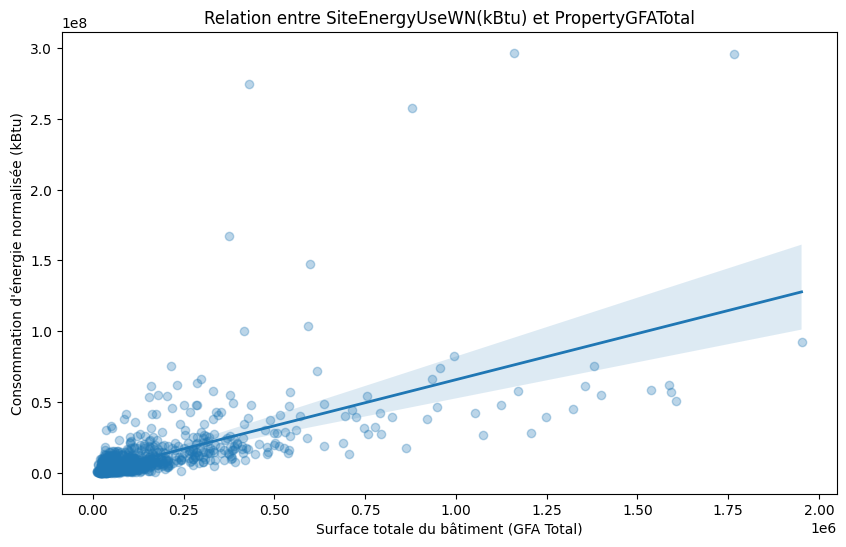

In [59]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="PropertyGFATotal",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et PropertyGFATotal")
plt.xlabel("Surface totale du bâtiment (GFA Total)")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

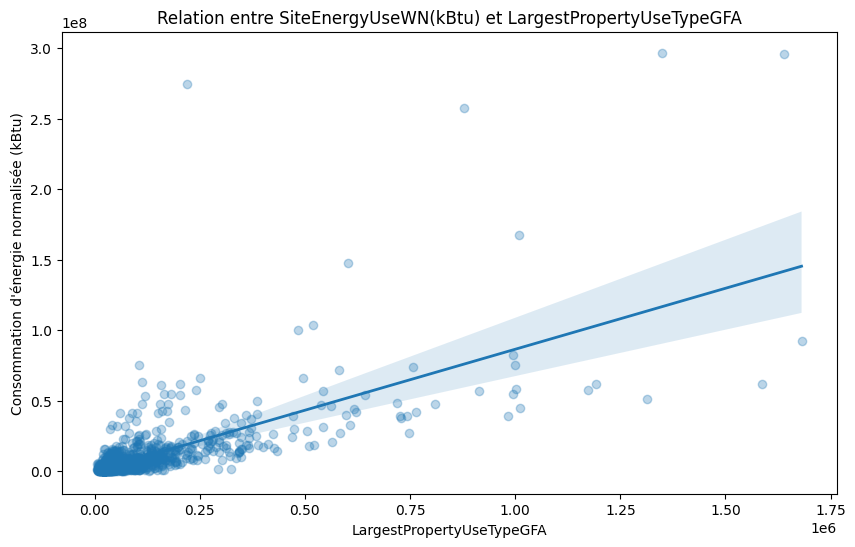

In [60]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="LargestPropertyUseTypeGFA",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et LargestPropertyUseTypeGFA")
plt.xlabel("LargestPropertyUseTypeGFA")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

Regardons tout les outliers.

In [61]:

x_col = 'LargestPropertyUseTypeGFA'
y_col = 'SiteEnergyUseWN(kBtu)'


q95_x = df[x_col].quantile(0.95)
q95_y = df[y_col].quantile(0.95)

outlier_filter = (df[x_col] > q95_x) | (df[y_col] > q95_y)

df_outliers= df[outlier_filter].copy()

# Colonnes descriptives pertinentes
columns_to_check = [
    'BuildingType', 
    'LargestPropertyUseType', 
    'Neighborhood', 
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'NumberofFloors',
    x_col, 
    y_col
]
df_outliers_caracteristiques = df_outliers[columns_to_check].sort_values(by=y_col, ascending=False)

In [62]:
df_outliers_caracteristiques.head(10)

,BuildingType,LargestPropertyUseType,Neighborhood,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),NumberofFloors,LargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu)
170,NonResidential,Hospital (General Medical & Surgical),EAST,1158691,0,1158691,8,1350182.0,296671744.0
618,NonResidential,Hospital (General Medical & Surgical),EAST,1765970,0,1765970,14,1639334.0,295929888.0
558,NonResidential,Data Center,DOWNTOWN,429405,0,429405,33,218997.0,274725984.0
124,NonResidential,Hospital (General Medical & Surgical),NORTHEAST,879000,0,879000,10,879000.0,257764208.0
3264,NonResidential,Hospital (General Medical & Surgical),EAST,374466,0,374466,8,1010135.0,167207104.0
167,NonResidential,Hospital (General Medical & Surgical),CENTRAL,597519,0,597519,5,601615.0,147299056.0
1690,NonResidential,Medical Office,EAST,591981,0,591981,3,520187.0,103985264.0
1672,NonResidential,Hospital (General Medical & Surgical),NORTHWEST,415632,0,415632,1,483520.0,100328264.0
559,NonResidential,Office,DOWNTOWN,1952220,319400,1632820,76,1680937.0,92537256.0
49,NonResidential,Hotel,DOWNTOWN,994212,146694,847518,34,994212.0,82318072.0


On remarque que les bâtiments consommant énormément sont des hôpitaux, des datas center, et des bueaux & hôtels avec de nombreux étages.

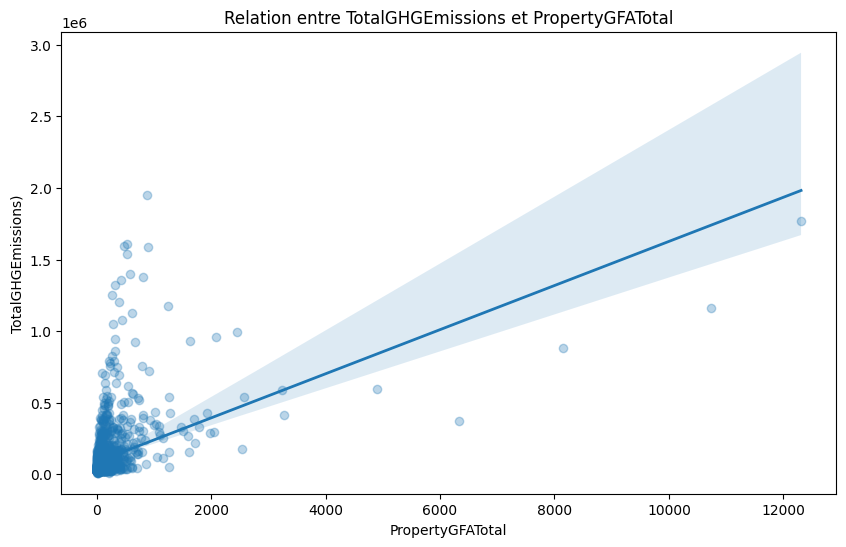

In [63]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="TotalGHGEmissions",
    y="PropertyGFATotal",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre TotalGHGEmissions et PropertyGFATotal")
plt.xlabel("PropertyGFATotal")
plt.ylabel("TotalGHGEmissions)")
plt.show()

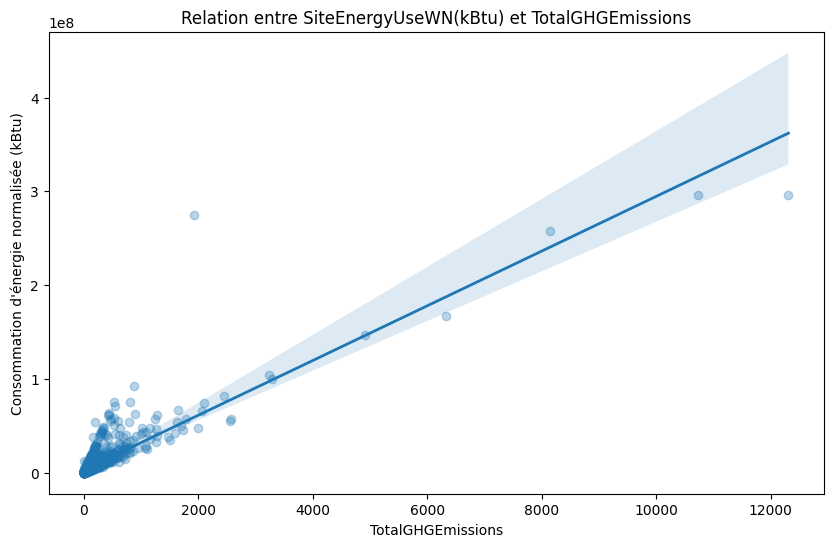

In [64]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="TotalGHGEmissions",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et TotalGHGEmissions")
plt.xlabel("TotalGHGEmissions")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

On remarque qu'il y a un lien entre la consommation d'énergie & la surface. On va donc continuer notre analyse avec la consommation d'énergie / surface

In [65]:
building_consumption_clean["SiteEnergyUseWN(kBtu/sf)"] = df["SiteEnergyUseWN(kBtu)"] / df["PropertyGFATotal"].replace(0, np.nan)

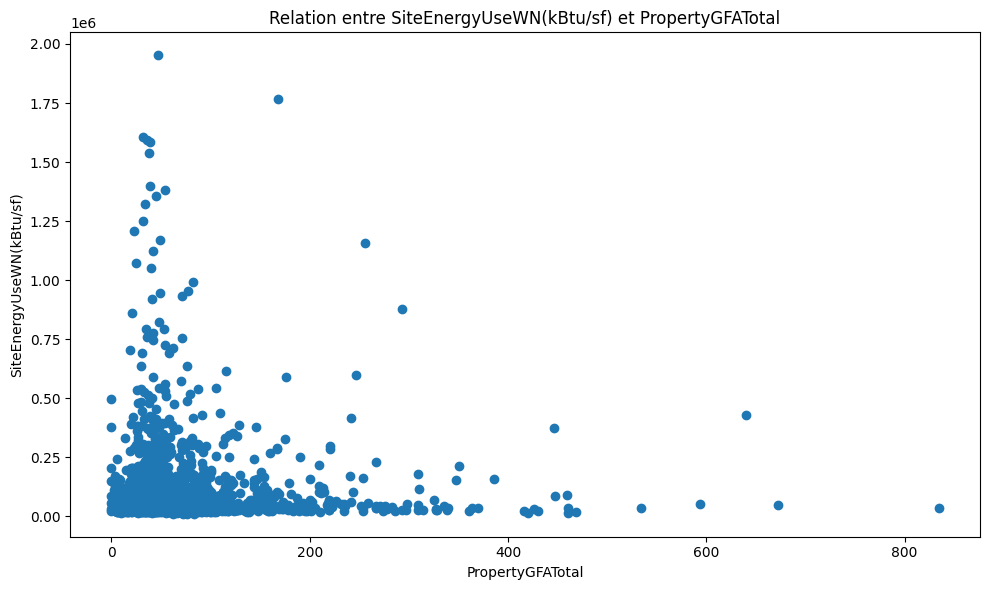

In [66]:

df = building_consumption_clean

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu/sf)"], df["PropertyGFATotal"])

plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUseWN(kBtu/sf)")
plt.title("Relation entre SiteEnergyUseWN(kBtu/sf) et PropertyGFATotal")

plt.tight_layout()
plt.show()

On ne peut pas déduire de relation entre la surface totale du bâtiment et sa consommation énergétique par square foot

#### Lien entre la consommation énergétique et l'année de construction

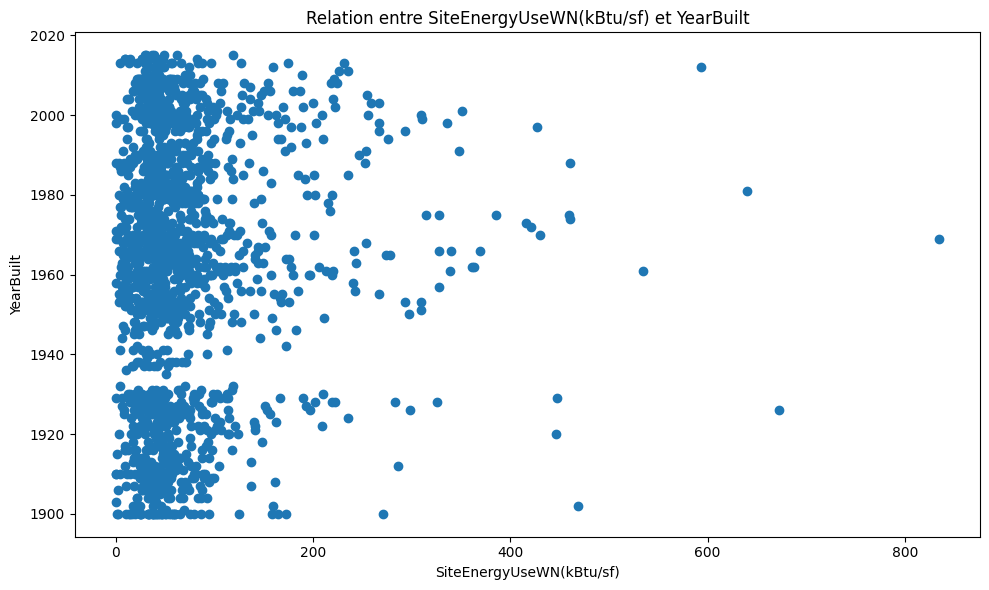

In [67]:

df = building_consumption_clean.copy()

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu/sf)"], df["YearBuilt"])

plt.xlabel("SiteEnergyUseWN(kBtu/sf)")
plt.ylabel("YearBuilt")
plt.title("Relation entre SiteEnergyUseWN(kBtu/sf) et YearBuilt")

plt.tight_layout()
plt.show()

On ne peut pas déduire de relation entre l'année de construction et la consommation électrique

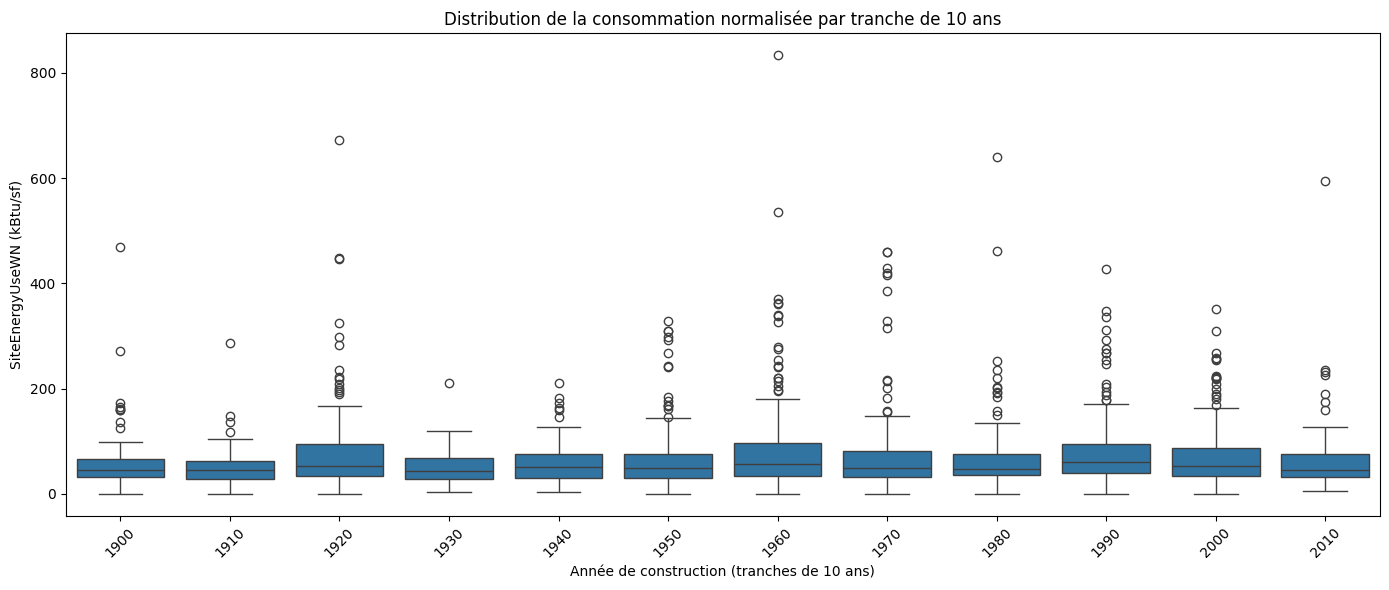

In [68]:
df["YearBuilt_10"] = (df["YearBuilt"] // 10) * 10
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="YearBuilt_10",
    y="SiteEnergyUseWN(kBtu/sf)"
)

plt.xticks(rotation=45)
plt.xlabel("Année de construction (tranches de 10 ans)")
plt.ylabel("SiteEnergyUseWN (kBtu/sf)")
plt.title("Distribution de la consommation normalisée par tranche de 10 ans")
plt.tight_layout()

plt.show()

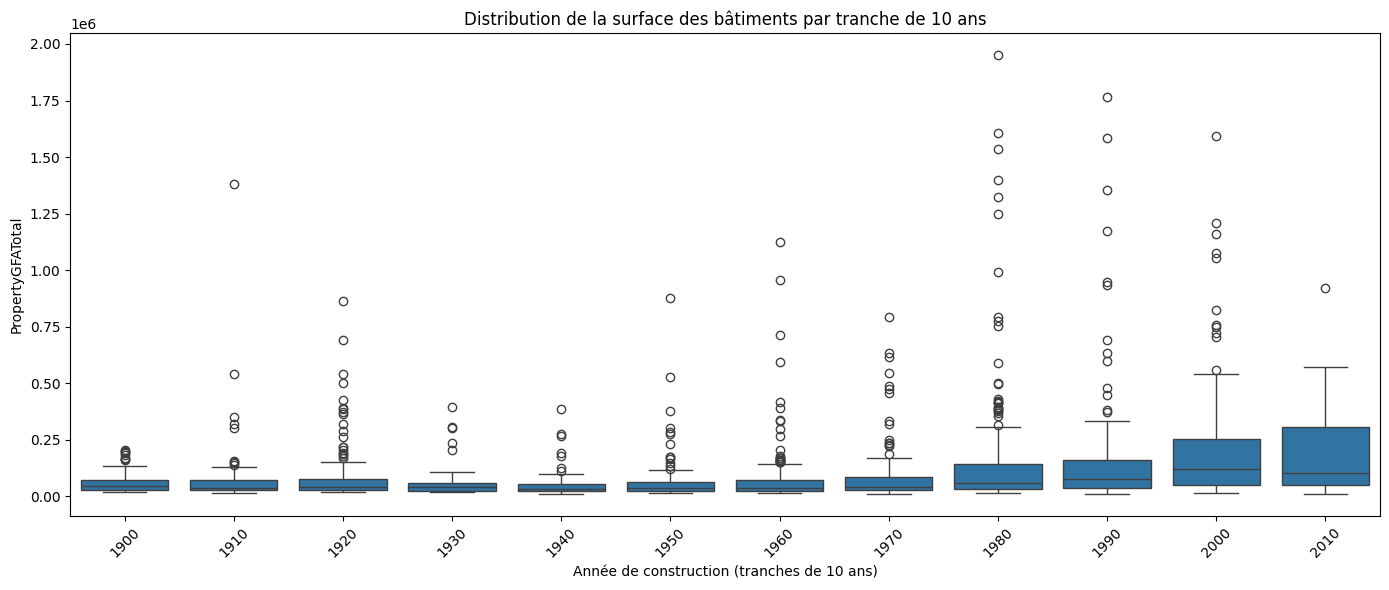

In [69]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="YearBuilt_10",
    y="PropertyGFATotal"
)

plt.xticks(rotation=45)
plt.xlabel("Année de construction (tranches de 10 ans)")
plt.ylabel("PropertyGFATotal")
plt.title("Distribution de la surface des bâtiments par tranche de 10 ans")
plt.tight_layout()

plt.show()

On remarque que la surface des bâtiments augmente au final des années. (hors années 40).Avec une nette augmentation pour les années > 2000.

#### Distribution de la consommation énergétique

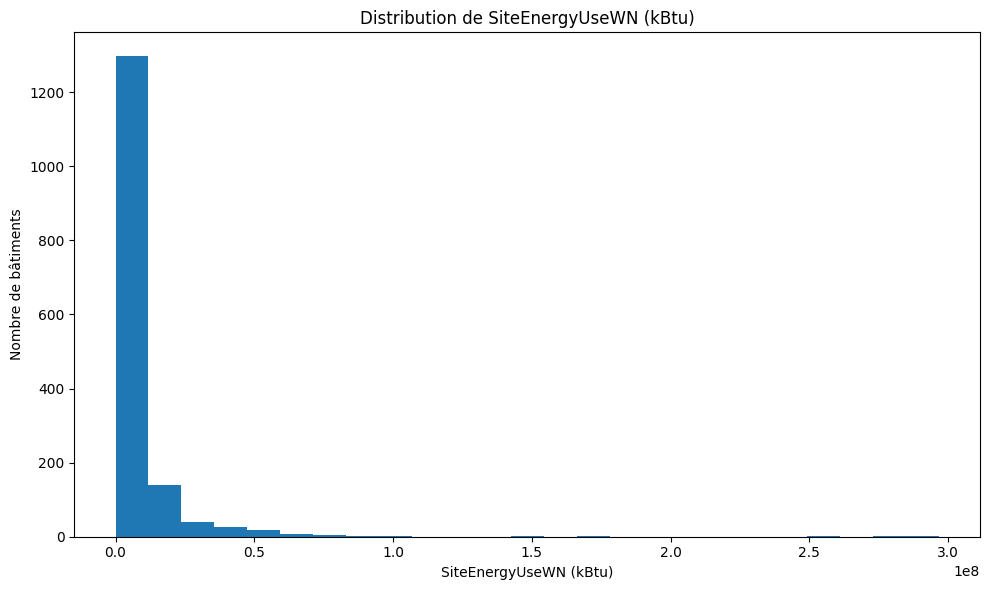

In [70]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["SiteEnergyUseWN(kBtu)"].dropna(),
    bins=25
)

plt.title("Distribution de SiteEnergyUseWN (kBtu)")
plt.xlabel("SiteEnergyUseWN (kBtu)")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

On remarque que la majorité des bâtiments consomment peu, sauf quelques uns qui semblent avoir des valeurs extrèment évelvés.

#### Distribution de la surface totale

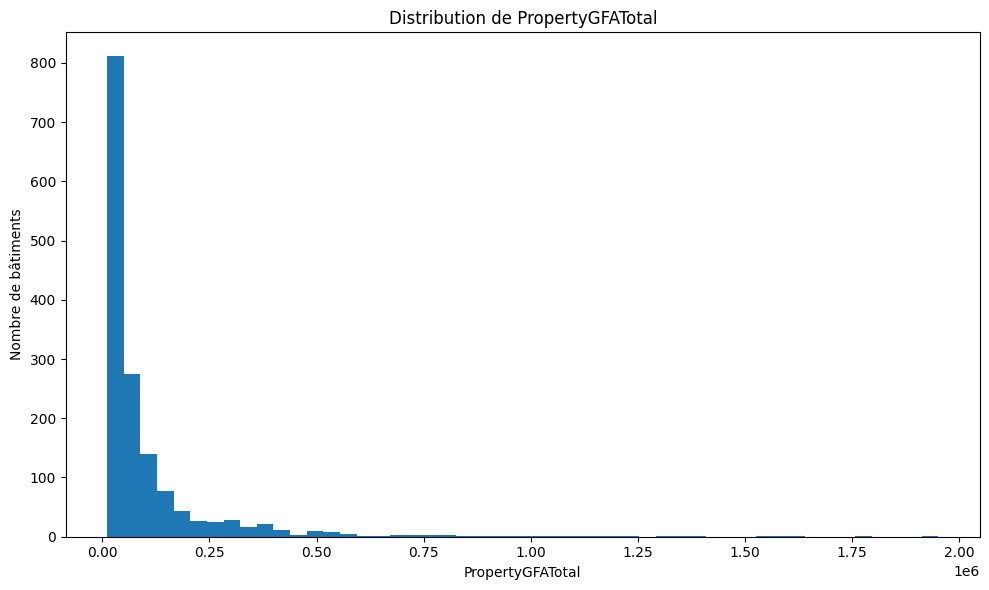

In [71]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["PropertyGFATotal"].dropna(),
    bins=50
)

plt.title("Distribution de PropertyGFATotal")
plt.xlabel("PropertyGFATotal")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

#### Distribution de la surface des bâtiments

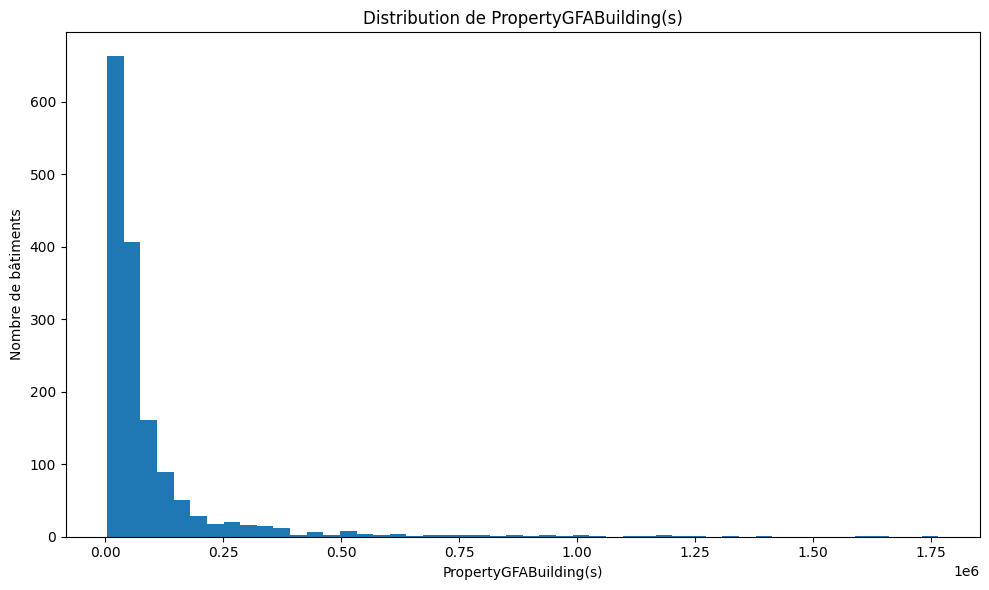

In [72]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["PropertyGFABuilding(s)"].dropna(),
    bins=50
)

plt.title("Distribution de PropertyGFABuilding(s)")
plt.xlabel("PropertyGFABuilding(s)")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

On retrouve une courbe similaire pour la surface qui ne correspond uniquement au bâtiment (sans les parking)

#### Distribution de la consommation énergétique en fonction des quartiers

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\755792323.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


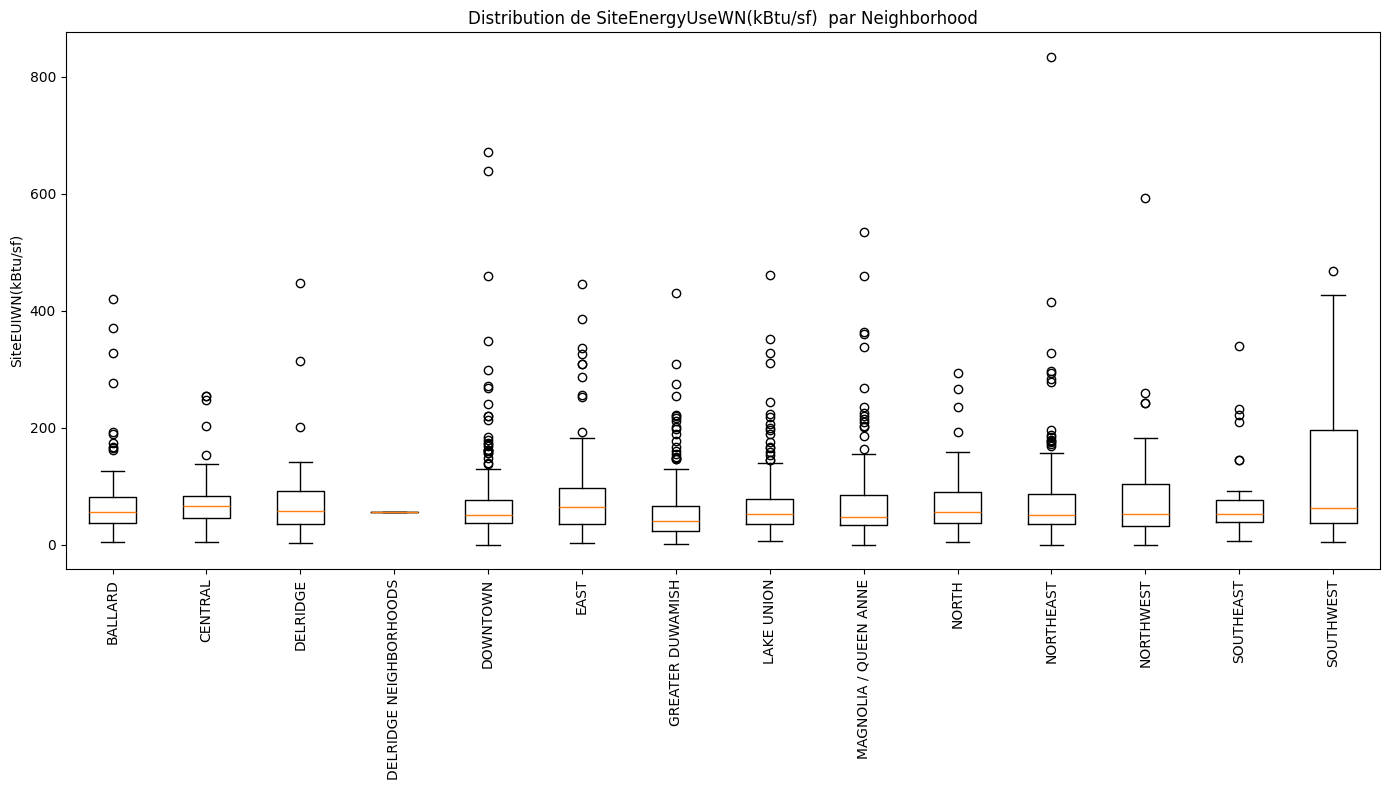

In [73]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["Neighborhood", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("Neighborhood")]

labels = df_plot.groupby("Neighborhood").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf)  par Neighborhood")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

#### Distribution de la consommation énergétique en fonction de la fonction première des bâtiments

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\3012280451.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


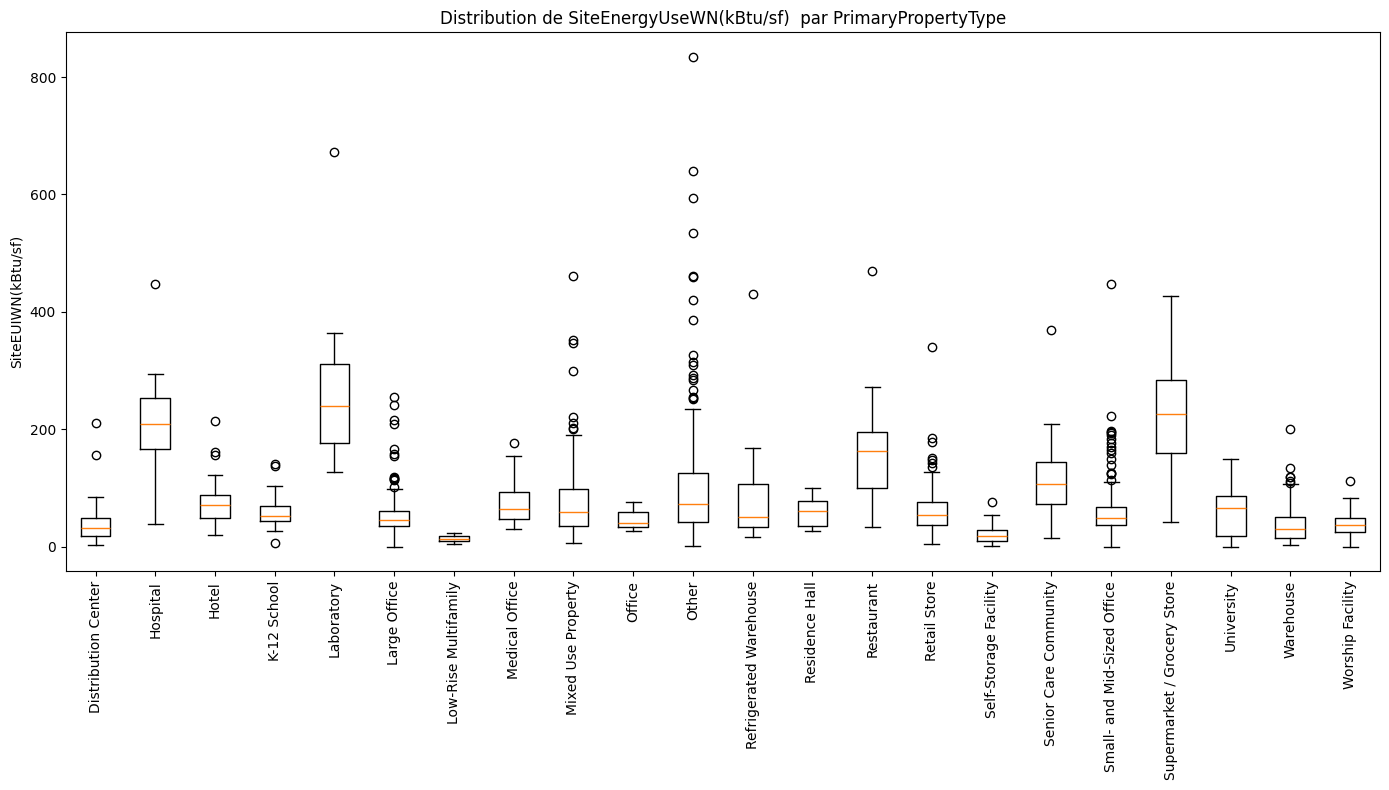

In [74]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["PrimaryPropertyType", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("PrimaryPropertyType")]

labels = df_plot.groupby("PrimaryPropertyType").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf)  par PrimaryPropertyType")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

Les hôpitaux sont les plus gros consommateurs d'énergie. faire par surface

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\1860180066.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


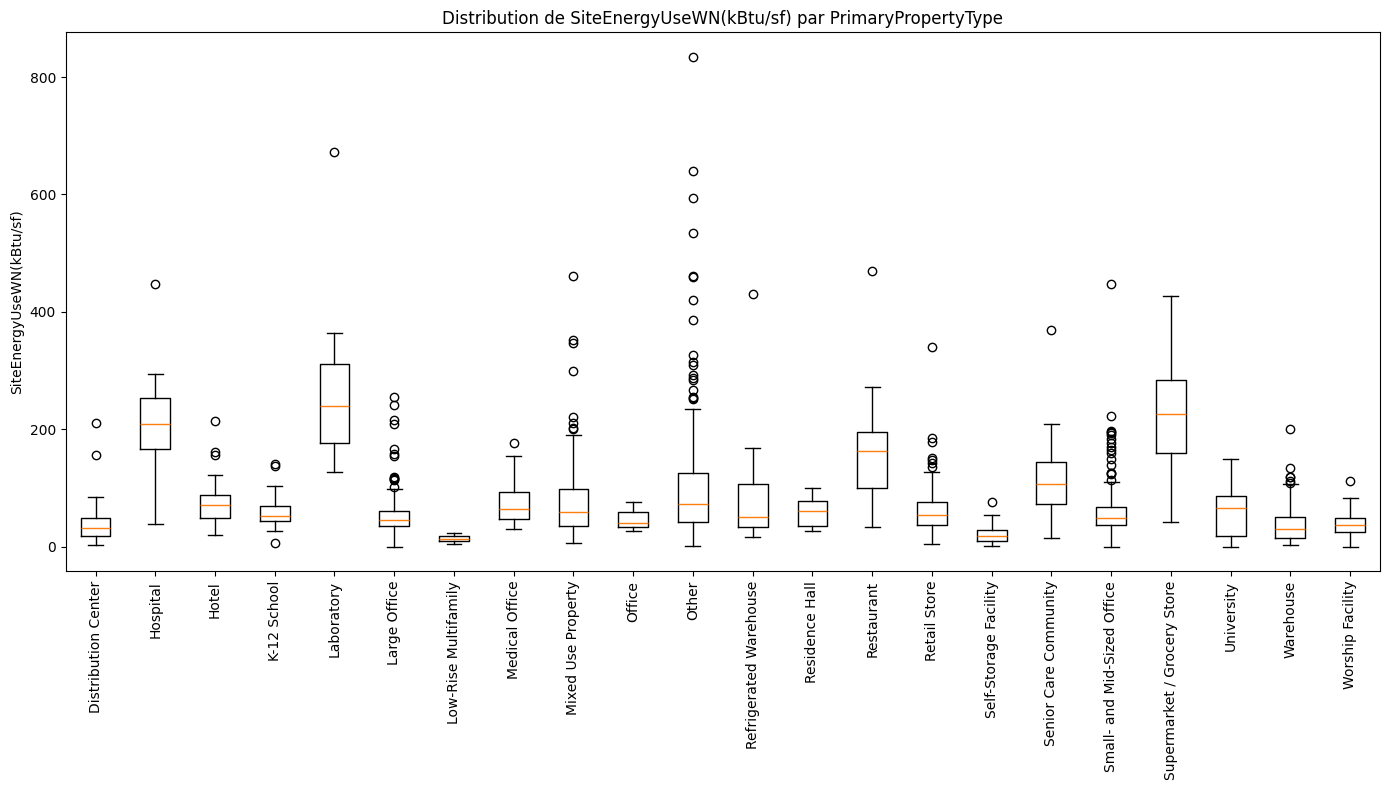

In [75]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["PrimaryPropertyType", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("PrimaryPropertyType")]

labels = df_plot.groupby("PrimaryPropertyType").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf) par PrimaryPropertyType")
plt.ylabel("SiteEnergyUseWN(kBtu/sf)")
plt.tight_layout()
plt.show()

Les hôpitaux et les Data Center sont les plus gros consommateur d'énergie

#### Proportion de LargestPropertyUse et PropertyGFA total 

In [76]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_LargestUse_to_TotalGFA'] = df['LargestPropertyUseTypeGFA'] / surface_total
df['Proportion_LargestUse_to_TotalGFA'].fillna(0)

0       1.000000
1       0.809918
2       0.791220
3       1.000000
4       0.703070
          ...   
3371    1.000000
3372    1.000000
3373    0.576347
3374    0.468123
3375    0.453007
Name: Proportion_LargestUse_to_TotalGFA, Length: 1541, dtype: float64

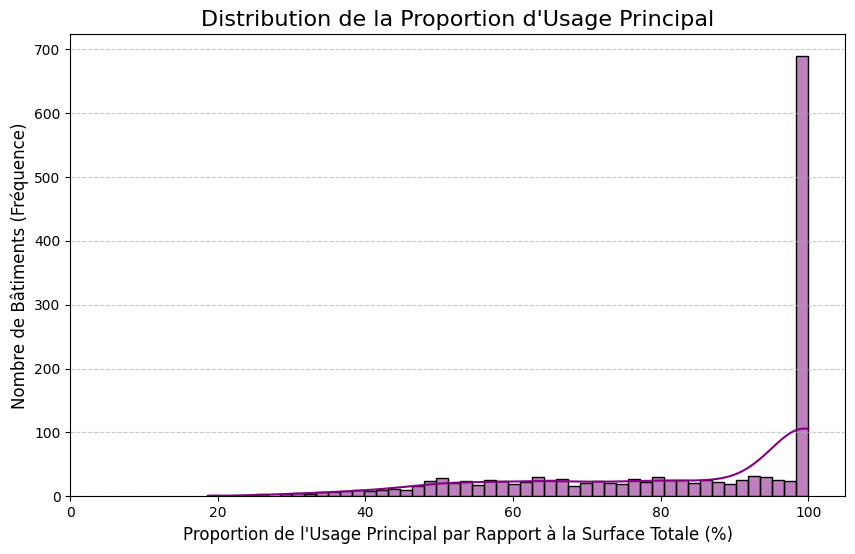

In [77]:
proportion_percent = df['Proportion_LargestUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))

# Création de l'histogramme avec la colonne PLAFONNÉE
sns.histplot(proportion_percent, bins=50, kde=True, color='purple', edgecolor='black')

plt.title("Distribution de la Proportion d'Usage Principal", fontsize=16)
plt.xlabel("Proportion de l'Usage Principal par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105) # Limiter l'axe X pour bien voir l'effet du plafonnement
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [78]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_SecondUse_to_TotalGFA'] = df['SecondLargestPropertyUseTypeGFA'] / surface_total
df['Proportion_SecondUse_to_TotalGFA'].fillna(0)

0       0.000000
1       0.145453
2       0.000000
3       0.000000
4       0.387339
          ...   
3371    0.000000
3372    0.000000
3373    0.423653
3374    0.461031
3375    0.438164
Name: Proportion_SecondUse_to_TotalGFA, Length: 1541, dtype: float64

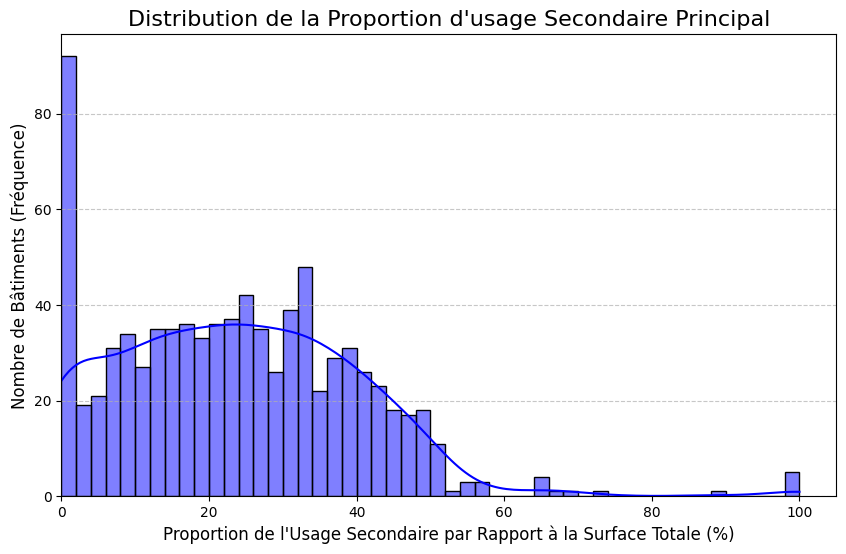

In [79]:
proportion_percent = df['Proportion_SecondUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))

sns.histplot(proportion_percent, bins=50, kde=True, color='blue', edgecolor='black')

plt.title("Distribution de la Proportion d'usage Secondaire Principal", fontsize=16)
plt.xlabel("Proportion de l'Usage Secondaire par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [80]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_ThirdUse_to_TotalGFA'] = df['ThirdLargestPropertyUseTypeGFA'] / surface_total
df['Proportion_ThirdUse_to_TotalGFA'].fillna(0)

0       0.000000
1       0.044629
2       0.000000
3       0.000000
4       0.000000
          ...   
3371    0.000000
3372    0.000000
3373    0.000000
3374    0.034324
3375    0.060686
Name: Proportion_ThirdUse_to_TotalGFA, Length: 1541, dtype: float64

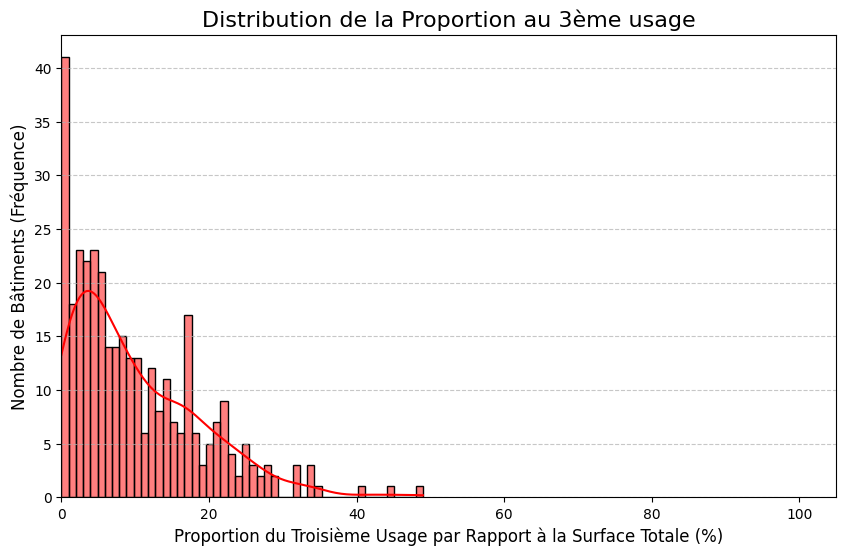

In [81]:
proportion_percent = df['Proportion_ThirdUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))


sns.histplot(proportion_percent, bins=50, kde=True, color='red', edgecolor='black')

plt.title("Distribution de la Proportion au 3ème usage", fontsize=16)
plt.xlabel("Proportion du Troisième Usage par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La proportion du Troisième Usage étant globalement faible, il ne sera pas la peine de la prendre en compte pour notre modèle prédictif.

#### TERMINER L'ANALYSE EXPLORATOIRE 

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

### Import des modules 

In [82]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modélisation 

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

#### Première Régression Linéaire

Le R² étant proche de 1, on peut dire que notre *algorithme fonctionne*, mais le score étant presque parfait, il y a du **data leakage**.

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [83]:
df = building_consumption_clean.copy()

In [84]:
target = 'SiteEnergyUseWN(kBtu)'
columns_to_drop = [target, 'OSEBuildingID', 'PropertyName'] 
df = df.drop(columns=columns_to_drop, errors='ignore') 


#### Matrice de Pearson

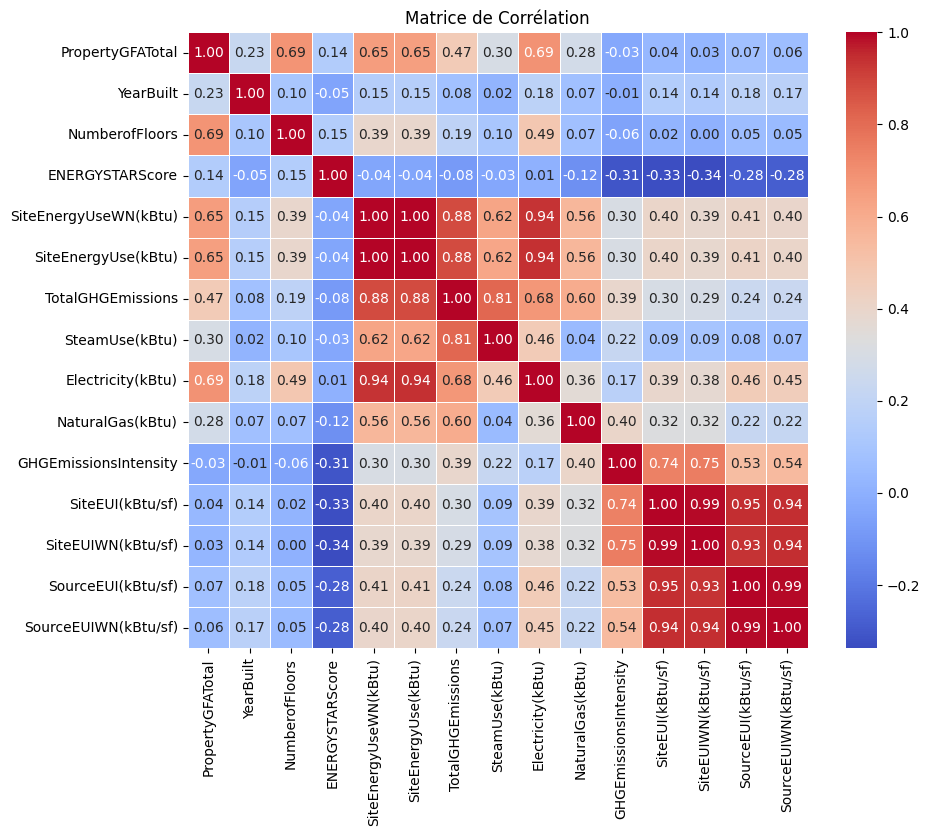

In [85]:
colonnes_correlation = [
    'PropertyGFATotal', 
    'YearBuilt', 
    'NumberofFloors',
    'ENERGYSTARScore', 
    'SiteEnergyUseWN(kBtu)', 
    'SiteEnergyUse(kBtu)', 
    'TotalGHGEmissions',
    'SteamUse(kBtu)', 
    'Electricity(kBtu)',
    'NaturalGas(kBtu)',
    'GHGEmissionsIntensity',
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
]

df_corr = building_consumption_clean[colonnes_correlation].copy()

# 2. Calcul de la matrice de corrélation
matrice_corr = df_corr.corr(method='pearson')

# 3. Visualisation (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
)
plt.title('Matrice de Corrélation')
plt.show()

Regardons maintenant les colonnes que l'on peut supprimer dans notre DF pour avoir une meilleure analyse. Elle risque de mal entraîner le modèle car elles sont trop ou peu corrélés avec notre cible.

In [86]:
# Selection des colonnes provoquant un Data Leakage
data_leakage_columns = [
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
    'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore', 'YearsENERGYSTARCertified',
    'SiteEnergyUseWN(kBtu/sf)'
]

# Autres colonnes à supprimer, qui ont peu d'intérêt pour notre modélisation
columns_to_drop = [
    'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA'
]

# Définition des différentes versions de la cible (Y) que nous devons aussi retirer de X.

# Construction de la liste finale des colonnes à supprimer.
features_to_drop = list(set(data_leakage_columns + columns_to_drop ))

df_without_leakage = df.drop(columns=features_to_drop)



In [87]:
# Séparation des colonnes en colonnes numérique et catégorielles
numeric_columns = df_without_leakage.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df_without_leakage.select_dtypes(exclude=np.number).columns.tolist()

#### Categorical Columns

In [88]:
#Vérifivcation qu'il existe des colonnes catégorielles avec des NaN
df_without_leakage[categorical_columns].isna().any()

BuildingType                    False
PrimaryPropertyType             False
Neighborhood                    False
ListOfAllPropertyUseTypes       False
LargestPropertyUseType           True
SecondLargestPropertyUseType     True
DefaultData                     False
ComplianceStatus                False
Outlier                          True
dtype: bool

On remarque que **LargestPropertyUseType** et **SecondLargestPropertyUseType** et **Outlier** contiennent des NaN

##### LargestPropertyUseType

In [89]:
df_without_leakage[df_without_leakage['LargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier
353,NonResidential,Self-Storage Facility,BALLARD,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,False,Compliant,NaN
1147,NonResidential,Hotel,DOWNTOWN,1910,1.0,8,61721,0,61721,Hotel,NaN,NaN,NaN,NaN,False,Compliant,NaN
2414,NonResidential,Small- and Mid-Sized Office,LAKE UNION,2008,1.0,4,48350,0,48350,Office,NaN,NaN,NaN,NaN,False,Compliant,NaN
2459,NonResidential,Restaurant,DOWNTOWN,1913,1.0,3,28800,0,28800,Restaurant,NaN,NaN,NaN,NaN,False,Compliant,NaN


On peut supposer que l'on peut appliquer les valeurs de **PrimaryPropertyType** à **LargestPropertyUseType**

In [90]:
mask = df_without_leakage['LargestPropertyUseType'].isna() & df_without_leakage['PrimaryPropertyType'].notna()
df_without_leakage.loc[mask, 'LargestPropertyUseType'] = df_without_leakage.loc[mask, 'PrimaryPropertyType']

In [91]:
df_without_leakage[df_without_leakage['LargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier


##### SecondLargestPropertyUseType

In [92]:
df_without_leakage[df_without_leakage['SecondLargestPropertyUseType'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,False,Compliant,NaN
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,False,Compliant,NaN
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,False,Compliant,NaN
5,Nonresidential COS,Other,DOWNTOWN,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,NaN,NaN,False,Compliant,NaN
6,NonResidential,Hotel,DOWNTOWN,1926,1.0,11,83008,0,83008,Hotel,Hotel,81352.0,NaN,NaN,False,Compliant,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,Nonresidential COS,Other,EAST,1912,1.0,1,23445,0,23445,Other - Recreation,Other - Recreation,23445.0,NaN,NaN,False,Compliant,NaN
3369,Nonresidential COS,Office,SOUTHEAST,1960,1.0,1,15398,0,15398,Office,Office,15398.0,NaN,NaN,True,Error - Correct Default Data,NaN
3370,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1982,1.0,1,18261,0,18261,Other - Recreation,Other - Recreation,18261.0,NaN,NaN,False,Compliant,NaN
3371,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,True,Error - Correct Default Data,NaN


Comme nous ne pouvons pas deviner quel est le second usage du bâtiment, on remplace ces valeurs par **Unknown**

In [93]:
df_without_leakage['SecondLargestPropertyUseType'] = df_without_leakage['SecondLargestPropertyUseType'].fillna('Unknown')

##### Outliers

In [94]:
df_without_leakage[df_without_leakage['Outlier'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Unknown,NaN,False,Compliant,NaN
1,NonResidential,Hotel,DOWNTOWN,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,False,Compliant,NaN
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Unknown,NaN,False,Compliant,NaN
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Unknown,NaN,False,Compliant,NaN
4,NonResidential,Hotel,DOWNTOWN,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,False,Compliant,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1,12294,0,12294,Office,Office,12294.0,Unknown,NaN,True,Error - Correct Default Data,NaN
3372,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,Unknown,NaN,False,Compliant,NaN
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,False,Compliant,NaN
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,False,Compliant,NaN


Pour les **outliers** qui  ne sont ni *High* ni *Low* on va les remplacer par **No**

In [95]:
df_without_leakage['Outlier'] = df_without_leakage['Outlier'].fillna('No')

##### Vérification qu'il n'existe plus de colonnes catégorielles vides

In [96]:
df_without_leakage[categorical_columns].isna().any()

BuildingType                    False
PrimaryPropertyType             False
Neighborhood                    False
ListOfAllPropertyUseTypes       False
LargestPropertyUseType          False
SecondLargestPropertyUseType    False
DefaultData                     False
ComplianceStatus                False
Outlier                         False
dtype: bool

#### Numeric Columns

In [97]:
df_without_leakage[numeric_columns].isna().any()

YearBuilt                          False
NumberofBuildings                  False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseTypeGFA           True
SecondLargestPropertyUseTypeGFA     True
dtype: bool

On remarque que **LargestPropertyUseTypeGFA** et **SecondLargestPropertyUseTypeGFA** ont des valeurs nulles.

##### LargestPropertyUseTypeGFA

In [98]:
df_without_leakage[df_without_leakage['LargestPropertyUseTypeGFA'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier
353,NonResidential,Self-Storage Facility,BALLARD,1946,2.0,2,111445,0,111445,"Fitness Center/Health Club/Gym, Office, Other ...",Self-Storage Facility,NaN,Unknown,NaN,False,Compliant,No
1147,NonResidential,Hotel,DOWNTOWN,1910,1.0,8,61721,0,61721,Hotel,Hotel,NaN,Unknown,NaN,False,Compliant,No
2414,NonResidential,Small- and Mid-Sized Office,LAKE UNION,2008,1.0,4,48350,0,48350,Office,Small- and Mid-Sized Office,NaN,Unknown,NaN,False,Compliant,No
2459,NonResidential,Restaurant,DOWNTOWN,1913,1.0,3,28800,0,28800,Restaurant,Restaurant,NaN,Unknown,NaN,False,Compliant,No


Pour ces  colonnes, on va remplacer la **LargestPropertyUseTypeGFA** par la **PropertyGFATotal** puisque que le **SecondLargestPropertyUseType** est *Unknown* et la colonne **PropertyGFABuilding(s)** est égale à la **LargestPropertyUseTypeGFA**

In [99]:
mask = (df_without_leakage['LargestPropertyUseTypeGFA'].isna()) & \
       (df_without_leakage['PropertyGFATotal'].notna())

df_without_leakage.loc[mask, 'LargestPropertyUseTypeGFA'] = \
    df_without_leakage.loc[mask, 'PropertyGFATotal']


In [100]:
df_without_leakage[df_without_leakage['LargestPropertyUseTypeGFA'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier


##### SecondLargestPropertyUseTypeGFA

In [101]:
df_without_leakage[df_without_leakage['SecondLargestPropertyUseTypeGFA'].isna()]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Unknown,NaN,False,Compliant,No
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Unknown,NaN,False,Compliant,No
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Unknown,NaN,False,Compliant,No
5,Nonresidential COS,Other,DOWNTOWN,1999,1.0,2,97288,37198,60090,Police Station,Police Station,88830.0,Unknown,NaN,False,Compliant,No
6,NonResidential,Hotel,DOWNTOWN,1926,1.0,11,83008,0,83008,Hotel,Hotel,81352.0,Unknown,NaN,False,Compliant,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,Nonresidential COS,Other,EAST,1912,1.0,1,23445,0,23445,Other - Recreation,Other - Recreation,23445.0,Unknown,NaN,False,Compliant,No
3369,Nonresidential COS,Office,SOUTHEAST,1960,1.0,1,15398,0,15398,Office,Office,15398.0,Unknown,NaN,True,Error - Correct Default Data,No
3370,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1982,1.0,1,18261,0,18261,Other - Recreation,Other - Recreation,18261.0,Unknown,NaN,False,Compliant,No
3371,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1,12294,0,12294,Office,Office,12294.0,Unknown,NaN,True,Error - Correct Default Data,No


In [137]:
# Masque : Lorsque le SecondLargestPropertyUseType N'EST PAS 'Unknown'
mask_non_unknown = df_without_leakage['SecondLargestPropertyUseType'] != 'Unknown'

# Calculer la superficie restante (Total - Largest GFA) et l'appliquer
df_without_leakage.loc[mask_non_unknown, 'SecondLargestPropertyUseTypeGFA'] = (
    df_without_leakage['PropertyGFATotal'] - df_without_leakage['LargestPropertyUseTypeGFA']
)



In [138]:
df_without_leakage

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier,SiteEnergyUseWN(kBtu/sf)
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,Unknown,0.0,False,Compliant,No,84.321754
1,NonResidential,Hotel,DOWNTOWN,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,19686.0,False,Compliant,No,83.661424
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,Unknown,0.0,False,Compliant,No,77.331177
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,Unknown,0.0,False,Compliant,No,113.287679
4,NonResidential,Hotel,DOWNTOWN,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,52135.0,False,Compliant,No,83.474786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1,12294,0,12294,Office,Office,12294.0,Unknown,0.0,True,Error - Correct Default Data,No,76.704343
3372,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,Unknown,0.0,False,Compliant,No,65.856609
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,False,Compliant,No,460.117390
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,7500.0,False,Compliant,No,55.516723


In [104]:
df_without_leakage[numeric_columns].isna().any()

YearBuilt                          False
NumberofBuildings                  False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseTypeGFA          False
SecondLargestPropertyUseTypeGFA    False
dtype: bool

In [105]:
# Retransformation des colonnes numériques et catégorielles
numeric_columns = df_without_leakage.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df_without_leakage.select_dtypes(exclude=np.number).columns.tolist()

### Regression Linéaire

In [106]:
features_to_keep = [
    'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
    'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 'DefaultData', 'ComplianceStatus',
    'Outlier'
]


In [107]:
y = building_consumption_clean['SiteEnergyUse(kBtu)']
X = df_without_leakage[features_to_keep].copy()
X = X.loc[y.index]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()) 
])
df_model = pd.concat([X, y], axis=1)

X_final = df_model[X.columns]
y_final = df_model[y.name]

pipeline.fit(X_final, y_final)
y_prediction = pipeline.predict(X)


In [139]:
# On calcule la MSE (Mean Squared Error) :
# C'est la moyenne des erreurs au carré. 
# Plus la MSE est basse, plus le modèle est précis.
mse = mean_squared_error(y, y_prediction)

# On calcule la RMSE (Root Mean Squared Error) :
# Racine carrée de la MSE : directement dans l’unité de la cible

rmse = np.sqrt(mse)

# On calcule la MAE (Mean Absolute Error) :
# Moyenne des valeurs absolues des erreurs.
# Moins sensible aux grands écarts que la RMSE.
mae = mean_absolute_error(y, y_prediction)

# On calcule le R² :
# Mesure le pouvoir explicatif du modèle (entre 0 et 1, parfois négatif).
# 1 = modèle parfait ; 0 = pas mieux qu'une moyenne ; négatif = pire qu'une moyenne.
r2 = r2_score(y, y_prediction)

# Affichage des résultats
print("Mesures du Modèle sur l'Ensemble Complet :")
print(f"R-carré (R2) : {r2:.4f}")
print(f"Erreur Quadratique Moyenne (RMSE) : {rmse:.2f} kBtu")
print(f"Erreur Absolue Moyenne (MAE) : {mae:.2f} kBtu")


Mesures du Modèle sur l'Ensemble Complet :
R-carré (R2) : 0.8817
Erreur Quadratique Moyenne (RMSE) : 6420735.43 kBtu
Erreur Absolue Moyenne (MAE) : 2763201.60 kBtu


#### Calcul de la différence entre le y_réel et le y_prediction

In [140]:

y_column_name = 'SiteEnergyUseWN(kBtu)'

y_series = building_consumption_clean[y_column_name].copy()

df_combined = pd.concat([X, y_series], axis=1)


X_final = df_combined[X.columns]
y_final = df_combined[y_series.name]


pipeline.fit(X_final, y_final)

# Prédiction
y_reel = pipeline.predict(X_final)


In [141]:
y_clean = y_reel.copy()

df_resultats = pd.DataFrame({
    'y_reel': y_clean,
    'y_predict': y_prediction,
})

df_resultats['erreur_pourcentage'] = (
    np.abs(df_resultats['y_reel'] - df_resultats['y_predict']) / df_resultats['y_reel']
) * 100


In [142]:
# Calcul du 90e percentile de la colonne d'erreur
percentile_90 = df_resultats['erreur_pourcentage'].quantile(0.90)

# Créer un masque pour les 90% d'observations avec la plus petite erreur (les 'non-outliers')
mask_90_percent = df_resultats['erreur_pourcentage'] <= percentile_90

# Séparer les 90%
df_90_percent = df_resultats[mask_90_percent]

# Séparer les 10% (pour analyse future)
df_10_percent = df_resultats[~mask_90_percent]

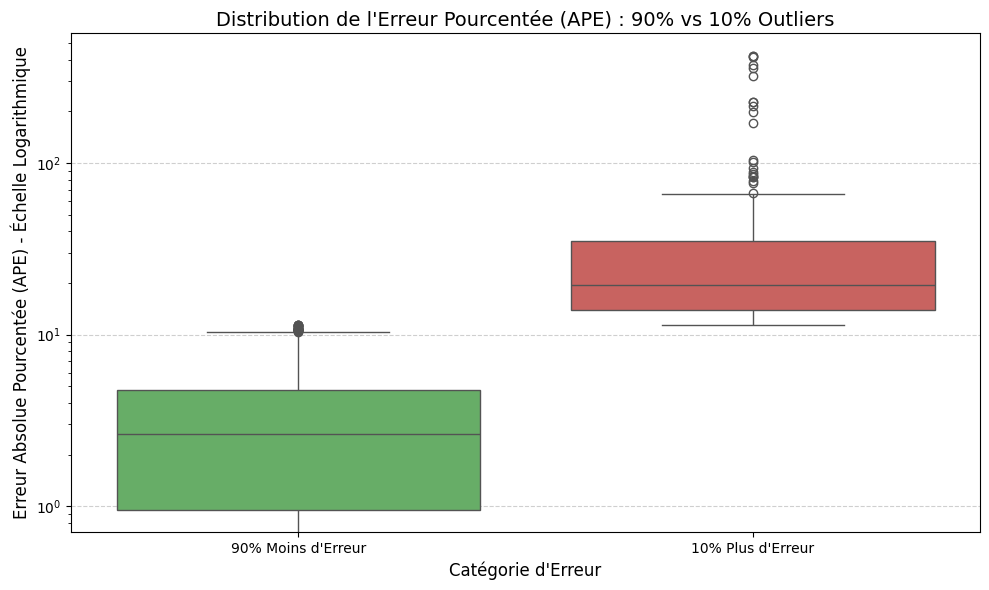

In [148]:
# --- 1. Préparation des Données ---

# 1.1 Ajout d'une colonne d'étiquette aux deux DataFrames
df_90_percent_plot = df_90_percent.copy()
df_10_percent_plot = df_10_percent.copy()

df_90_percent_plot['Catégorie'] = '90% Moins d\'Erreur'
df_10_percent_plot['Catégorie'] = '10% Plus d\'Erreur'

# 1.2 Concaténation des deux DataFrames
df_boxplot = pd.concat([df_90_percent_plot, df_10_percent_plot])

# --- 2. Génération du Box Plot ---

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Catégorie',
    y='erreur_pourcentage',
    data=df_boxplot,
    palette=['#5cb85c', '#d9534f'],
    hue='Catégorie'
)

plt.yscale('log') 

plt.title("Distribution de l'Erreur Pourcentée (APE) : 90% vs 10% Outliers", fontsize=14)
plt.xlabel("Catégorie d'Erreur", fontsize=12)
plt.ylabel("Erreur Absolue Pourcentée (APE) - Échelle Logarithmique", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [115]:
all_index = df_10_percent.index.to_list()


In [116]:
current_index = df_combined.index
valid_indices = [idx for idx in all_index if idx in current_index]
df_combined.loc[valid_indices]

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier,SiteEnergyUseWN(kBtu)
27,NonResidential,Hotel,DOWNTOWN,2001,1.0,10,171866,38281,133585,Hotel,Hotel,128909.0,Unknown,0.0,False,Compliant,No,1.117141e+07
89,NonResidential,Other,NORTHEAST,1941,1.0,4,56521,0,56521,Other,Other,49000.0,Unknown,0.0,False,Compliant,No,6.367210e+06
166,NonResidential,Hotel,DOWNTOWN,1999,1.0,0,934292,0,934292,"Hotel, Other, Parking, Restaurant, Retail Store",Hotel,495536.0,Parking,438756.0,False,Compliant,No,6.650284e+07
207,NonResidential,Large Office,DOWNTOWN,2000,1.0,23,747747,205076,542671,"Office, Parking, Restaurant",Office,542461.0,Parking,205286.0,False,Compliant,No,3.169370e+07
265,NonResidential,Warehouse,NORTHWEST,1960,1.0,1,52311,0,52311,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,51116.0,Unknown,0.0,False,Compliant,No,1.109137e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,NonResidential,Warehouse,GREATER DUWAMISH,1977,1.0,1,29380,0,29380,"Non-Refrigerated Warehouse, Office, Other",Non-Refrigerated Warehouse,16768.0,Office,12612.0,False,Compliant,No,8.789333e+05
1418,NonResidential,Senior Care Community,LAKE UNION,2006,1.0,14,724148,0,724148,Senior Care Community,Senior Care Community,726000.0,Unknown,0.0,False,Compliant,No,3.912083e+07
1422,NonResidential,Worship Facility,SOUTHWEST,1957,1.0,1,23562,0,23562,"Office, Worship Facility",Worship Facility,18278.0,Office,5284.0,False,Compliant,No,5.317372e+05
1436,NonResidential,K-12 School,EAST,1968,1.0,5,43594,0,43594,K-12 School,K-12 School,40809.0,Unknown,0.0,False,Compliant,No,2.699616e+06


In [117]:
df_combined.loc[valid_indices].join(df_10_percent).sort_values(
    by='erreur_pourcentage', 
    ascending=False
)

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,...,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,DefaultData,ComplianceStatus,Outlier,SiteEnergyUseWN(kBtu),y_reel,y_predict,erreur_pourcentage
1168,NonResidential,Other,LAKE UNION,1969,1.0,1,30730,0,30730,Other,...,30730.0,Unknown,0.0,False,Compliant,No,3.269018e+06,1.328302e+04,-4.257491e+04,420.521184
784,NonResidential,Mixed Use Property,DOWNTOWN,1903,1.0,3,28600,0,28600,"Office, Restaurant, Retail Store",...,12000.0,Retail Store,16600.0,False,Compliant,No,1.167560e+06,2.508592e+04,1.302792e+05,419.332050
1269,NonResidential,Small- and Mid-Sized Office,LAKE UNION,1920,1.0,3,28380,12180,16200,Office,...,28380.0,Unknown,0.0,False,Compliant,No,1.503529e+06,1.558526e+04,7.999218e+04,413.255202
681,NonResidential,Warehouse,GREATER DUWAMISH,1979,1.0,1,26380,0,26380,"Non-Refrigerated Warehouse, Office",...,23620.0,Office,2760.0,False,Compliant,No,5.269553e+05,5.452519e+04,-1.494191e+05,374.036744
934,NonResidential,Residence Hall,NORTHEAST,1993,1.0,3,28572,0,28572,"Parking, Residence Hall/Dormitory",...,22000.0,Parking,6572.0,False,Compliant,No,2.759012e+06,4.019001e+04,1.833616e+05,356.236770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,NonResidential,Hotel,DOWNTOWN,2001,1.0,10,171866,38281,133585,Hotel,...,128909.0,Unknown,0.0,False,Compliant,No,1.117141e+07,4.711374e+06,4.153430e+06,11.842496
1162,NonResidential,Retail Store,LAKE UNION,1911,1.0,2,20516,0,20516,"Hotel, Retail Store",...,10155.0,Hotel,10361.0,False,Compliant,No,1.109483e+06,3.699151e+06,3.269585e+06,11.612545
1189,NonResidential,Other,NORTHWEST,1964,1.0,2,92080,0,92080,Other,...,92129.0,Unknown,0.0,False,Compliant,No,5.368434e+06,8.791947e+05,7.775424e+05,11.561971
789,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1908,1.0,3,28800,0,28800,"Non-Refrigerated Warehouse, Office, Other",...,21600.0,Other,7200.0,False,Compliant,No,1.423579e+06,9.069687e+05,8.024379e+05,11.525294


In [119]:
df = building_consumption_clean.copy()

new_column = "SiteEnergyUseWN(kBtu/sf)" 

df[new_column] = df["SiteEnergyUseWN(kBtu)"] / df["PropertyGFATotal"]

serie = df[new_column]

df_without_leakage.loc[:, new_column] = serie.loc[df_without_leakage.index]

##### Analyse de la consommation par quartier

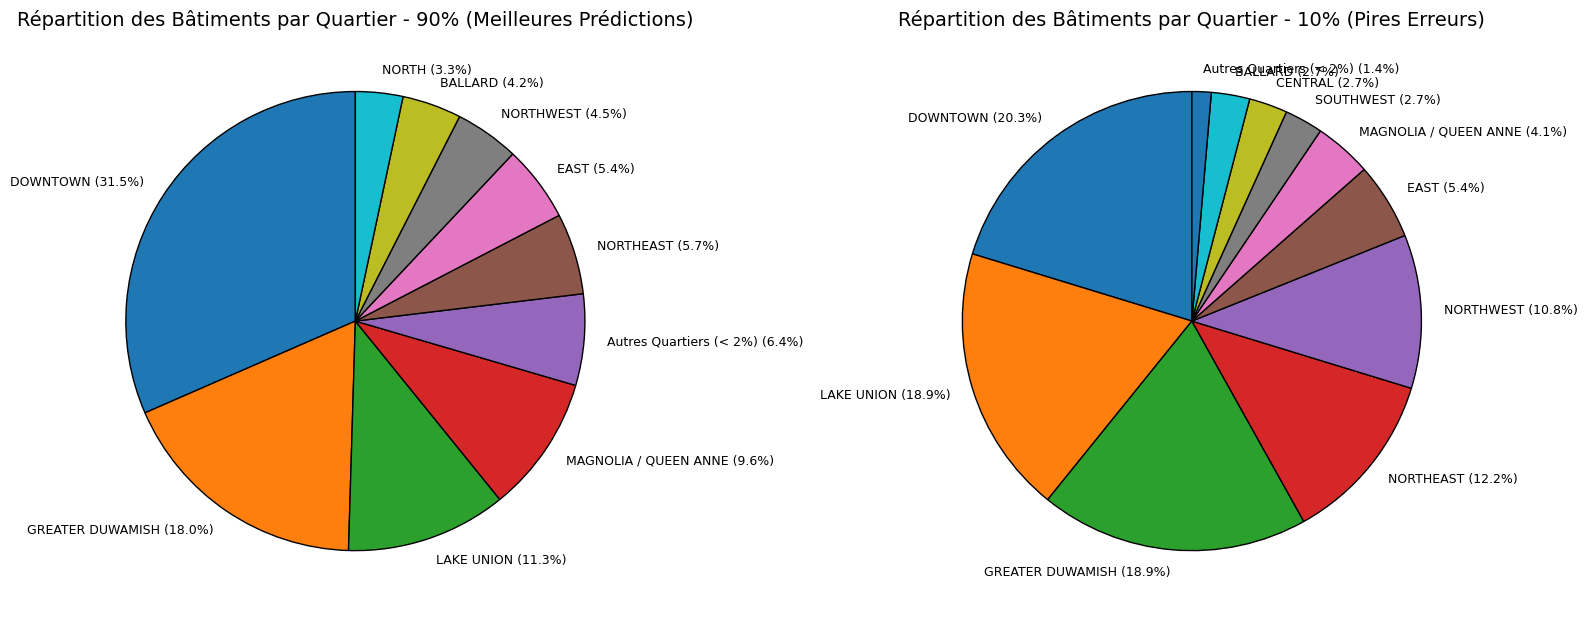

In [151]:
# --- 1. AJOUTER LES FEATURES CLÉS DANS LE DATAFRAME DE RÉSULTATS ---
# Nous allons ajouter 'Neighborhood' au DataFrame de résultats avant de le splitter.

feature_col = 'Neighborhood'
# 1. Obtenir la colonne 'Neighborhood' de df_combined (qui est aligné avec X_final)
neighborhood_series = df_combined[feature_col].copy()

# 2. Joindre cette série à df_resultats (ils devraient avoir le même index de travail)
# Note : Nous devons nous assurer que df_resultats n'a pas été reset_index entre-temps.
df_resultats[feature_col] = neighborhood_series 

# --- 2. Recalculer le split avec la colonne 'Neighborhood' incluse ---
percentile_90 = df_resultats['erreur_pourcentage'].quantile(0.90)
mask_90_percent = df_resultats['erreur_pourcentage'] <= percentile_90

# Séparer les 90% (Contient maintenant 'Neighborhood')
df_90_percent_working = df_resultats[mask_90_percent].copy()

# Séparer les 10% (Contient maintenant 'Neighborhood')
df_10_percent_working = df_resultats[~mask_90_percent].copy()


# --- 3. Exécution de la fonction de préparation (qui est maintenant simple) ---

# Fonction d'Aide pour préparer les données du Camembert (inchangée)
def prepare_pie_data(df_input, title_suffix):
    # ... (le corps de la fonction est le même) ...
    threshold = 2.0
    counts = df_input[feature_col].value_counts()
    total_buildings = counts.sum()
    percentages = (counts / total_buildings) * 100
    
    # Regrouper les petites catégories (< 2%)
    small = percentages[percentages < threshold]
    main = percentages[percentages >= threshold].copy()
    
    if small.sum() > 0:
        main['Autres Quartiers (< 2%)'] = small.sum()
        
    df_pie_freq = main.sort_values(ascending=False)
    
    labels = [f'{lab} ({val:.1f}%)' for lab, val in zip(df_pie_freq.index, df_pie_freq.values)]
    
    return df_pie_freq.values, labels, f"Répartition des Bâtiments par Quartier - {title_suffix}"


# Préparer les données pour le 90% (Meilleures Prédictions)
values_90, labels_90, title_90 = prepare_pie_data(df_90_percent_working, '90% (Meilleures Prédictions)')

# Préparer les données pour le 10% (Pires Erreurs)
values_10, labels_10, title_10 = prepare_pie_data(df_10_percent_working, '10% (Pires Erreurs)')


# --- 4. Tracé des deux Camemberts (Subplots) ---

plt.figure(figsize=(16, 8))
# ... (Reste du code de tracé) ...
plt.subplot(1, 2, 1)
plt.pie(
    values_90, 
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_90, fontsize=14)

plt.subplot(1, 2, 2)
plt.pie(
    values_10, 
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_10, fontsize=14)

plt.tight_layout()
plt.show()

Il y a une grande différence entre **DOWNTOWN**, **LAKE UNIONT**

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\2197572007.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='Neighborhood', ylabel='SiteEnergyUseWN(kBtu/sf)'>

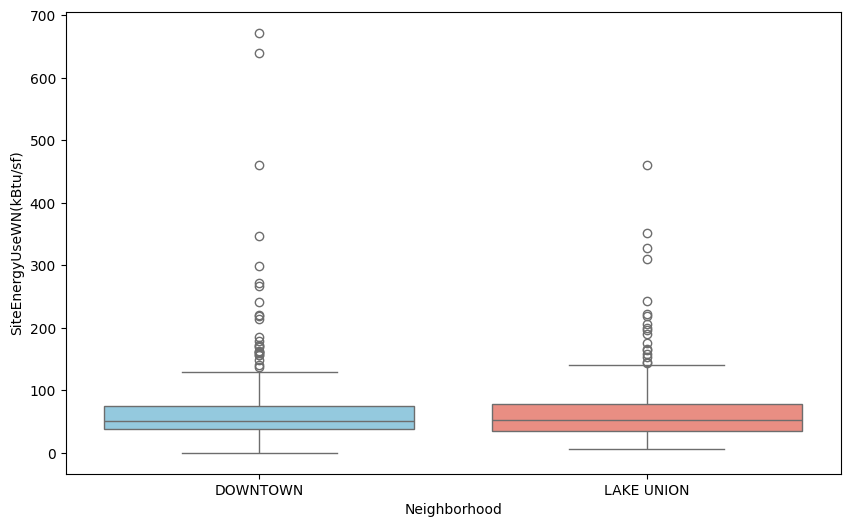

In [152]:
feature_col = 'Neighborhood'
neighborhoods = ['DOWNTOWN', 'LAKE UNION']

consommation_col = 'SiteEnergyUseWN(kBtu/sf)'

df_filtre = df[df[feature_col].isin(neighborhoods)]

plt.figure(figsize=(10, 6))

sns.boxplot(
    x=feature_col,
    y=consommation_col,
    data=df_filtre,
    palette=['skyblue', 'salmon']
)

<Axes: xlabel='PrimaryPropertyType', ylabel='SiteEnergyUseWN(kBtu/sf)'>

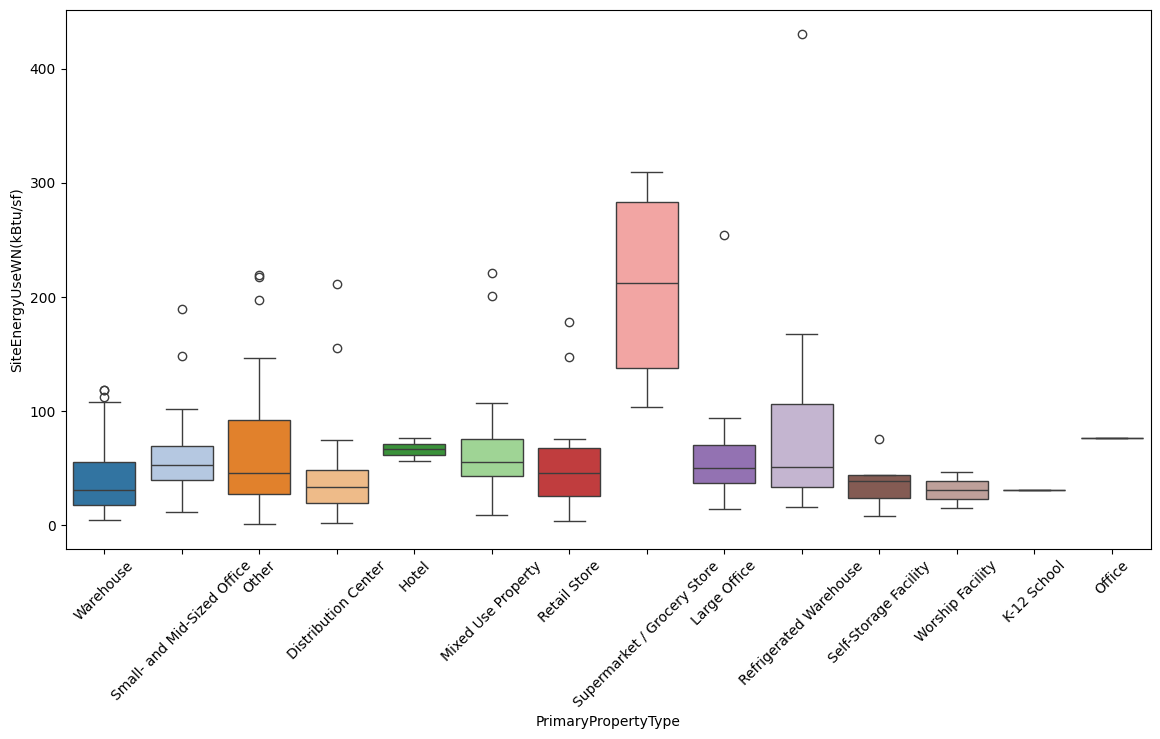

In [122]:
consommation_col = 'SiteEnergyUseWN(kBtu/sf)'
feature_column = 'PrimaryPropertyType'
feature_neigborhood = 'Neighborhood'

df_gd = df[df[feature_neigborhood] == 'GREATER DUWAMISH'].copy()


plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(
    x=feature_column,
    y=consommation_col,
    data=df_gd,
    palette='tab20',
    hue=feature_column
)

On voit que ce sont les **Supermachés** qui consomment le plus à **GREATER DUWAMISH**

In [123]:
feature_column = 'PrimaryPropertyType'
feature_column_neighborhood = 'Neighborhood' 

columns_cibles = [
    'LargestPropertyUseType',
    'YearBuilt',
    'PropertyGFATotal',      
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'SiteEnergyUseWN(kBtu/sf)'
]

mask_gb= (df[feature_column_neighborhood] == 'GREATER DUWAMISH') & \
                    (df[feature_column] == 'Supermarket / Grocery Store')

df_gb_details = df.loc[mask_gb, columns_cibles].copy()

df_gb_details

,LargestPropertyUseType,YearBuilt,PropertyGFATotal,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu/sf)
357,Supermarket/Grocery Store,2008,63225,1.0,1,0,63225,103.164120
600,Supermarket/Grocery Store,1963,50785,1.0,1,0,50785,149.513341
1509,Supermarket/Grocery Store,1953,26092,1.0,1,0,26092,309.366377
1678,Supermarket/Grocery Store,1965,21603,1.0,1,0,21603,274.369277


<Axes: xlabel='PrimaryPropertyType', ylabel='SiteEnergyUseWN(kBtu/sf)'>

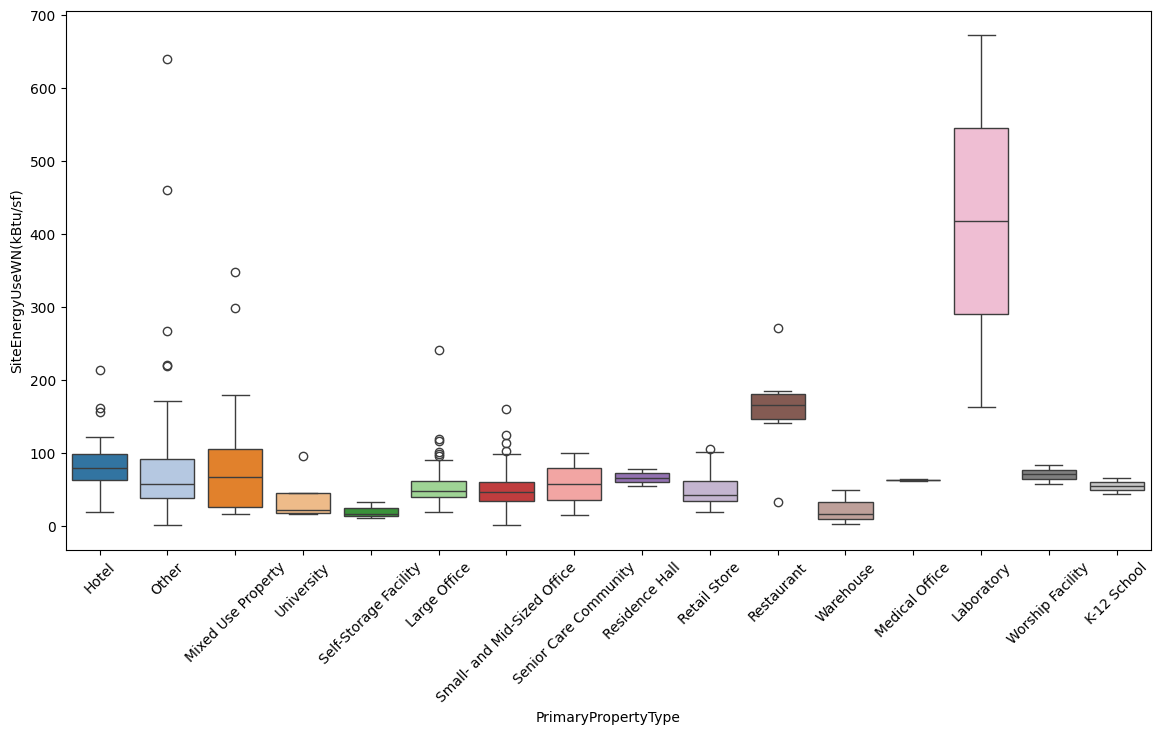

In [124]:
consommation_col = 'SiteEnergyUseWN(kBtu/sf)'
feature_column = 'PrimaryPropertyType'
feature_neigborhood = 'Neighborhood'

df_downtown = df[df[feature_neigborhood] == 'DOWNTOWN'].copy()


plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(
    x=feature_column,
    y=consommation_col,
    data=df_downtown,
    palette='tab20',
    hue=feature_column
)

On voit que ce sont les **laboratoires** qui consomment le plus à **DOWNTOWN**

Index du 90% retirés car manquants dans df_combined: 547
Index du 10% retirés car manquants dans df_combined: 80

Statistiques de la nouvelle colonne :
Performance_Modele
Bonne Prédiction (90%)       840
Non Classifié                627
Mauvaise Prédiction (10%)     74
Name: count, dtype: int64


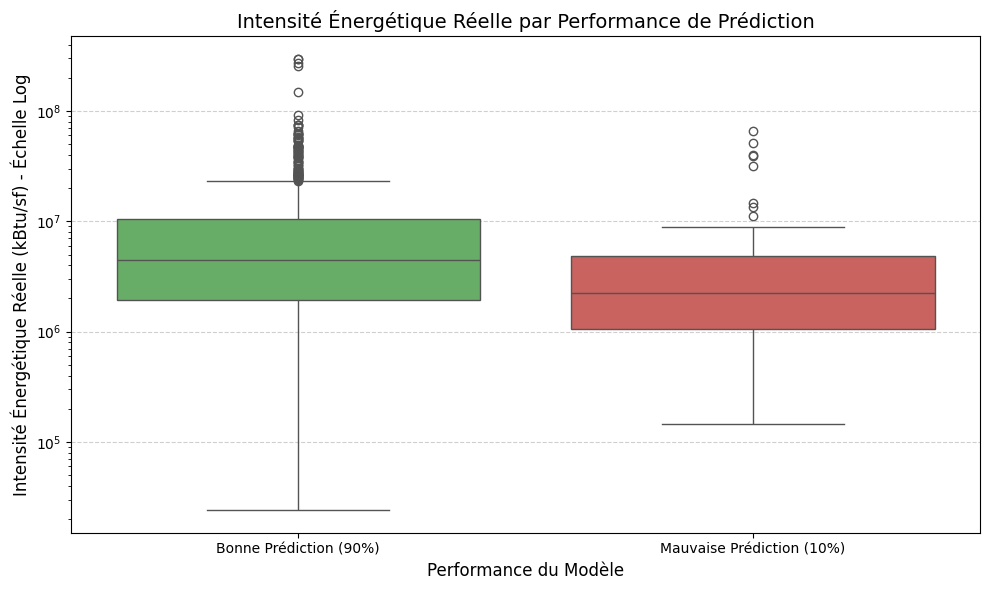

In [171]:

# --- 1. Préparation de la nouvelle colonne dans df_combined ---

# Liste des index qui existent DANS df_combined ET DANS df_90_percent
valid_90_indices = df_90_percent.index.intersection(df_combined.index)

# Liste des index qui existent DANS df_combined ET DANS df_10_percent
valid_10_indices = df_10_percent.index.intersection(df_combined.index)

# Initialiser la nouvelle colonne
df_combined['Performance_Modele'] = 'Non Classifié' 

# 1. Étiqueter les "Bons" (90%) - Utilisation des index VALIDÉS
df_combined.loc[valid_90_indices, 'Performance_Modele'] = 'Bonne Prédiction (90%)'

# 2. Étiqueter les "Mauvais" (10%) - Utilisation des index VALIDÉS
df_combined.loc[valid_10_indices, 'Performance_Modele'] = 'Mauvaise Prédiction (10%)'

# Vérification du nombre d'index manquant (à titre informatif)
missing_90 = len(df_90_percent) - len(valid_90_indices)
missing_10 = len(df_10_percent) - len(valid_10_indices)

print(f"Index du 90% retirés car manquants dans df_combined: {missing_90}")
print(f"Index du 10% retirés car manquants dans df_combined: {missing_10}")
print("\nStatistiques de la nouvelle colonne :")
print(df_combined['Performance_Modele'].value_counts())


# --- 2. Box Plot de la Consommation (y_reel) vs. Performance ---

# Par le nom réel de la colonne de la cible (Y) dans df_combined :
y_column_name = 'SiteEnergyUseWN(kBtu)' # <<< NOM DE COLONNE CORRIGÉ !

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Performance_Modele',
    y=y_column_name, # y_column_name vaut maintenant 'SiteEnergyUseWN(kBtu)'
    data=df_combined[df_combined['Performance_Modele'] != 'Non Classifié'], 
    palette=['#5cb85c', '#d9534f'],
    order=['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)'],
    hue='Performance_Modele'
)

plt.yscale('log') 

plt.title("Intensité Énergétique Réelle par Performance de Prédiction", fontsize=14)
plt.xlabel("Performance du Modèle", fontsize=12)
plt.ylabel("Intensité Énergétique Réelle (kBtu/sf) - Échelle Log", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\792445222.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\792445222.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\792445222.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\mcourte\AppData\Local\Temp\ipykernel_6156\792445222.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

ATTENTION : La colonne 'SiteEnergyUseWN(kBtu/sf)' n'existe pas dans df_combined et est ignorée pour ce tracé.


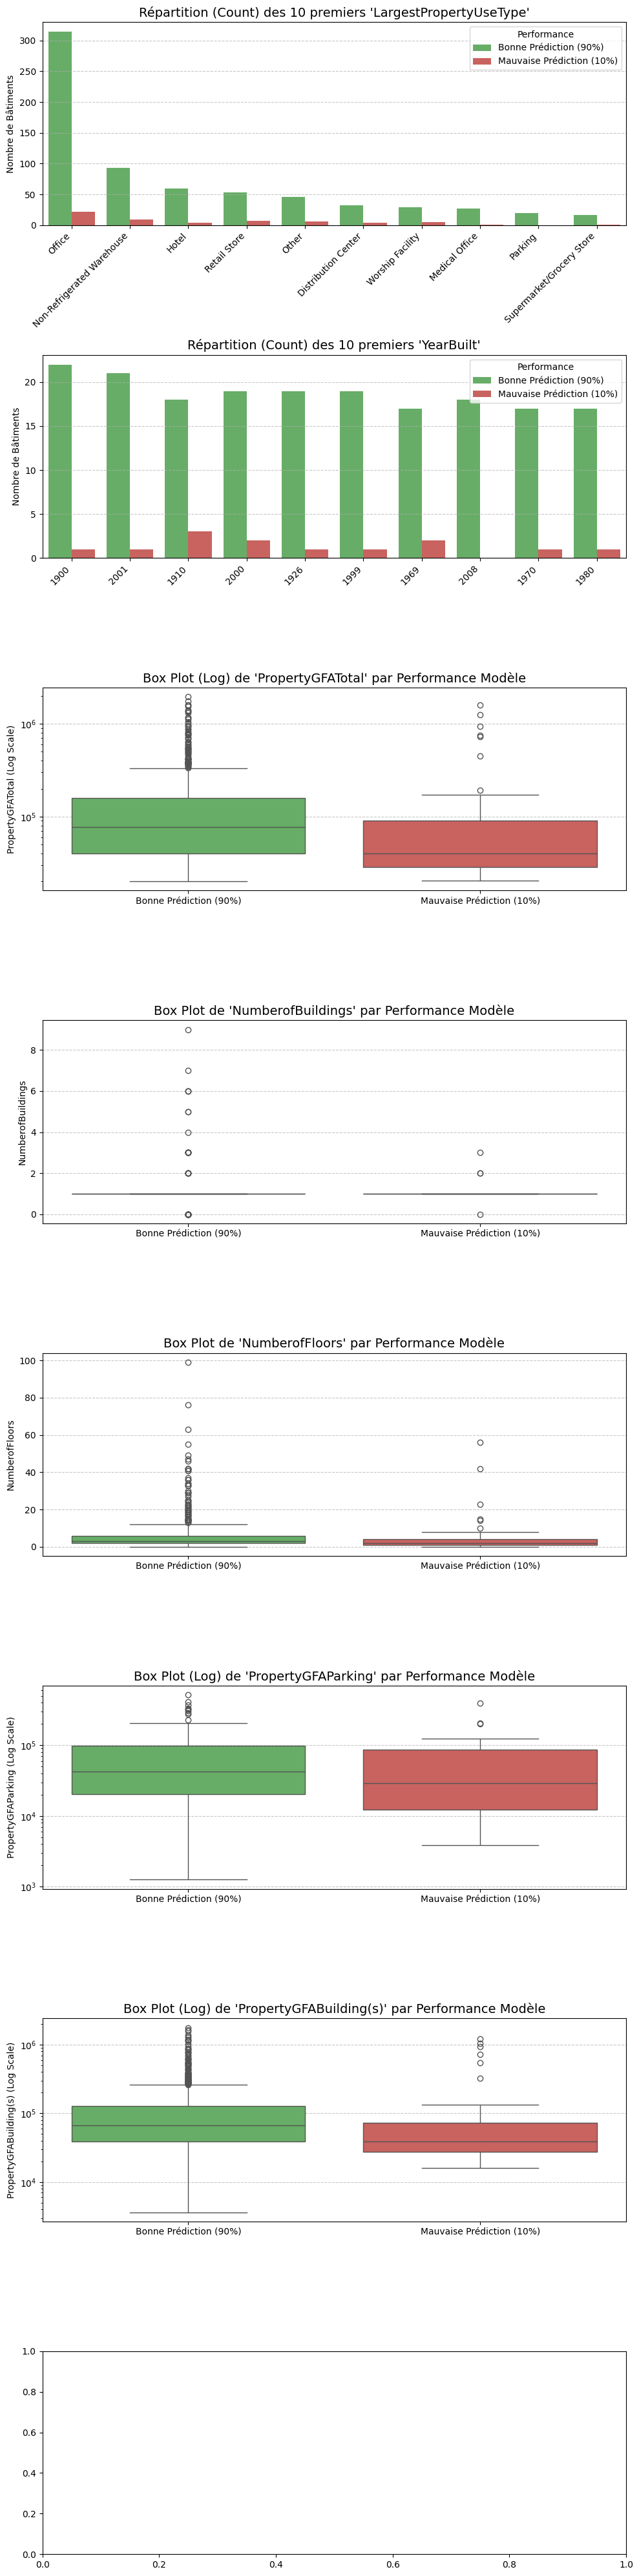

In [175]:


# Colonnes à visualiser
columns_cibles = [
    'LargestPropertyUseType',
    'YearBuilt',
    'PropertyGFATotal',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'SiteEnergyUseWN(kBtu/sf)' # Note : Cette colonne n'est pas dans df_combined si y_final était 'SiteEnergyUseWN(kBtu)'
]

# Colonne de classification des performances (créée précédemment)
performance_col = 'Performance_Modele'

# Filtrer df_combined pour inclure uniquement les lignes classifiées
df_plot_data = df_combined[df_combined[performance_col] != 'Non Classifié'].copy()

# Ordre d'affichage des catégories
order_cats = ['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)']

# --- ITÉRATION ET TRACÉ ---
num_cols = len(columns_cibles)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 5 * num_cols))

# Assurez-vous que axes est un tableau si num_cols = 1
if num_cols == 1:
    axes = [axes]

for i, col in enumerate(columns_cibles):
    ax = axes[i]
    
    # Gestion des colonnes manquantes (si vous utilisez SiteEnergyUseWN(kBtu/sf) au lieu de SiteEnergyUseWN(kBtu))
    if col not in df_plot_data.columns:
        print(f"ATTENTION : La colonne '{col}' n'existe pas dans df_combined et est ignorée pour ce tracé.")
        continue

    # Déterminer si c'est une variable numérique ou catégorielle
    if df_plot_data[col].dtype in [np.float64, np.int64] and col not in ['YearBuilt', 'NumberofBuildings', 'NumberofFloors']:
        # Variables numériques pour lesquelles on peut utiliser une échelle log
        
        # S'assurer que les valeurs sont positives pour le log
        temp_data = df_plot_data[df_plot_data[col] > 0] 

        sns.boxplot(
            x=performance_col,
            y=col,
            data=temp_data,
            palette=['#5cb85c', '#d9534f'],
            order=order_cats,
            ax=ax,
        )
        
        # Utilisation de l'échelle log pour les variables continues très étalées
        ax.set_yscale('log')
        ax.set_title(f"Box Plot (Log) de '{col}' par Performance Modèle", fontsize=14)
        ax.set_ylabel(f'{col} (Log Scale)')
        
    else:
        # Variables catégorielles ou dénombrement (comme YearBuilt)
        
        # Pour les variables catégorielles, on utilise un countplot
        if df_plot_data[col].dtype == 'object' or col in ['YearBuilt']:
             # Créer un décompte des catégories
            category_counts = df_plot_data.groupby([performance_col, col]).size().reset_index(name='Count')
            
            # Pour éviter trop de barres, on ne trace que les 10 premières catégories par groupe
            top_categories = df_plot_data[col].value_counts().nlargest(10).index
            category_counts = category_counts[category_counts[col].isin(top_categories)]
            
            sns.barplot(
                x=col,
                y='Count',
                hue=performance_col,
                data=category_counts,
                palette=['#5cb85c', '#d9534f'],
                ax=ax,
                order=top_categories
            )
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_title(f"Répartition (Count) des 10 premiers '{col}'", fontsize=14)
            ax.set_ylabel('Nombre de Bâtiments')
            ax.legend(title='Performance')
            
        else:
             # Autres variables numériques (non log)
            sns.boxplot(
                x=performance_col,
                y=col,
                data=df_plot_data,
                palette=['#5cb85c', '#d9534f'],
                order=order_cats,
                ax=ax,
                hue=performance_col
            )
            ax.set_title(f"Box Plot de '{col}' par Performance Modèle", fontsize=14)
            ax.set_ylabel(col)

    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

##### Analyse de la consommation par LargestPropertyUseType

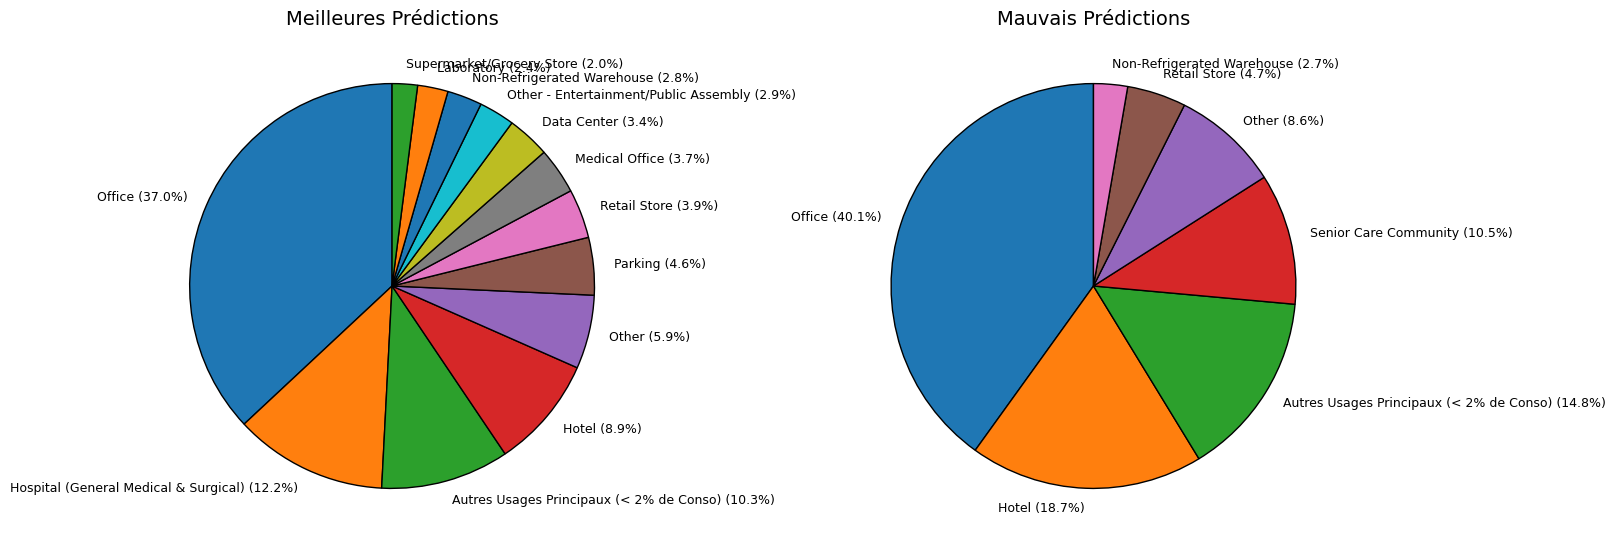

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Variables Globales ---
feature_col = 'LargestPropertyUseType'
threshold = 2.0 # Seuil de regroupement en pourcentage de la population du sous-échantillon

# --- Fonction d'Aide pour préparer les données du Camembert ---
def prepare_pie_data_consumption(df_input, title_suffix):
    """
    Calcule la consommation totale par catégorie dans df_input, 
    calcule le pourcentage et regroupe les petites catégories.
    """
    consommation_col = 'SiteEnergyUseWN(kBtu)'
    
    # S'assurer que les colonnes nécessaires sont présentes
    if feature_col not in df_input.columns:
        raise ValueError(f"La colonne '{feature_col}' est manquante dans le DataFrame d'entrée.")
    if consommation_col not in df_input.columns:
        raise ValueError(f"La colonne de consommation '{consommation_col}' est manquante dans le DataFrame d'entrée.")


    # 1. Calcul de la somme de consommation par catégorie
    sum_by_category = df_input.groupby(feature_col)[consommation_col].sum()

    # 2. Calcul du pourcentage
    total_consumption = sum_by_category.sum()
    percentages = (sum_by_category / total_consumption) * 100
    
    categories = percentages.sort_values(ascending=False)
    
    # 3. Regrouper les petites catégories (< 2%)
    small = categories[categories < threshold]
    main = categories[categories >= threshold].copy()
    
    if small.sum() > 0:
        main['Autres Usages Principaux (< 2% de Conso)'] = small.sum()
        
    df_pie_freq = main.sort_values(ascending=False)
    
    # Préparer les étiquettes pour l'affichage
    labels = [f'{lab} ({val:.1f}%)' for lab, val in zip(df_pie_freq.index, df_pie_freq.values)]
    
    return df_pie_freq.values, labels, title_suffix


# --- 1. Préparation des données pour les deux groupes (avec gestion de l'index) ---

# Le DataFrame df_combined contient toutes les features ('LargestPropertyUseType') et la cible ('SiteEnergyUseWN(kBtu)')
# et est aligné sur les index de df_resultats.

# Créer une version de travail des 10% et des 90% pour ajouter les colonnes de features et de cible
df_90_percent_working = df_90_percent.copy()
df_10_percent_working = df_10_percent.copy()

# Colonnes à joindre : LargestPropertyUseType et la colonne de Consommation (cible réelle)
cols_to_join = [feature_col, 'SiteEnergyUseWN(kBtu)'] 

# Joindre les colonnes nécessaires de df_combined par l'index
df_90_percent_working = df_90_percent_working.join(df_combined[cols_to_join], how='left')
df_10_percent_working = df_10_percent_working.join(df_combined[cols_to_join], how='left')


# --- 2. Préparation des données pour les Camemberts ---
values_90, labels_90, title_90 = prepare_pie_data_consumption(df_90_percent_working, 'Meilleures Prédictions')
values_10, labels_10, title_10 = prepare_pie_data_consumption(df_10_percent_working, 'Mauvais Prédictions')


# --- 3. Tracé des deux Camemberts (Subplots) ---

plt.figure(figsize=(16, 8))

# Camembert pour les 90%
plt.subplot(1, 2, 1)
plt.pie(
    values_90, 
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_90, fontsize=14) 

# Camembert pour les 10%
plt.subplot(1, 2, 2)
plt.pie(
    values_10, 
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_10, fontsize=14)

plt.tight_layout()
plt.show()

##### Analyse de la consommation par PrimaryPropertyType

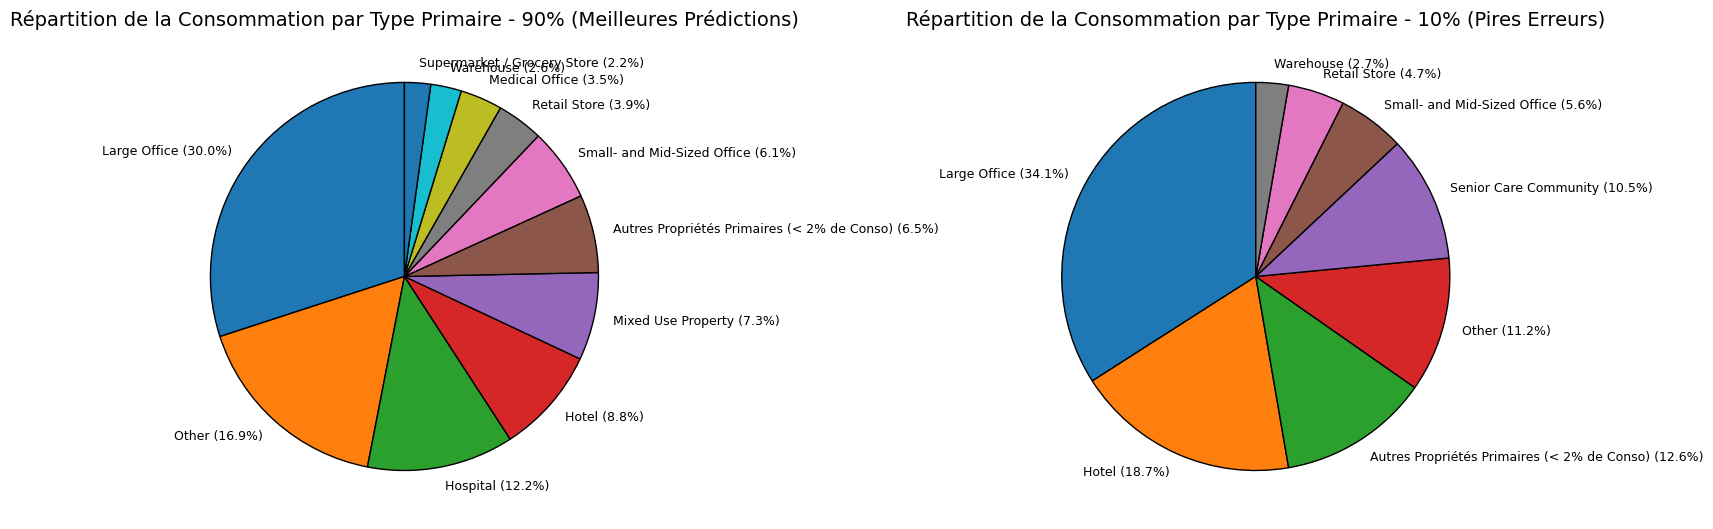

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Variables Globales ---
feature_col = 'PrimaryPropertyType'
threshold = 2.0 # Seuil de regroupement en pourcentage de la consommation du sous-échantillon

# --- Fonction d'Aide pour préparer les données du Camembert ---
def prepare_pie_data_consumption(df_input, title_suffix):
    """
    Calcule la consommation totale par catégorie dans df_input, 
    calcule le pourcentage et regroupe les petites catégories.
    """
    consommation_col = 'SiteEnergyUseWN(kBtu)'
    
    # Vérification (à ce stade, ces colonnes devraient être présentes grâce à l'étape de jointure)
    if feature_col not in df_input.columns or consommation_col not in df_input.columns:
        # Ceci ne devrait pas arriver si le code précédent a bien fonctionné.
        raise ValueError("Colonnes manquantes dans le DataFrame de travail. Assurez-vous que df_combined contient les données et que la jointure a réussi.")


    # 1. Calcul de la somme de consommation par catégorie
    sum_by_category = df_input.groupby(feature_col)[consommation_col].sum()

    # 2. Calcul du pourcentage
    total_consumption = sum_by_category.sum()
    percentages = (sum_by_category / total_consumption) * 100
    
    categories = percentages.sort_values(ascending=False)
    
    # 3. Regrouper les petites catégories (< 2%)
    small = categories[categories < threshold]
    main = categories[categories >= threshold].copy()
    
    if small.sum() > 0:
        main['Autres Propriétés Primaires (< 2% de Conso)'] = small.sum()
        
    df_pie_freq = main.sort_values(ascending=False)
    
    # Préparer les étiquettes pour l'affichage
    labels = [f'{lab} ({val:.1f}%)' for lab, val in zip(df_pie_freq.index, df_pie_freq.values)]
    
    return df_pie_freq.values, labels, f"Répartition de la Consommation par Type Primaire - {title_suffix}"


# --- 1. Préparation des données pour les deux groupes (Jointure des colonnes nécessaires) ---

# Définition des colonnes à joindre (Features + Cible)
cols_to_join = [feature_col, 'SiteEnergyUseWN(kBtu)'] 

# Créer une version de travail des 10% et des 90%
df_90_percent_working = df_90_percent.copy()
df_10_percent_working = df_10_percent.copy()

# Joindre les colonnes nécessaires de df_combined par l'index (cette étape gère l'alignement)
df_90_percent_working = df_90_percent_working.join(df_combined[cols_to_join], how='left')
df_10_percent_working = df_10_percent_working.join(df_combined[cols_to_join], how='left')


# --- 2. Préparation des données pour les Camemberts ---
values_90, labels_90, title_90 = prepare_pie_data_consumption(df_90_percent_working, '90% (Meilleures Prédictions)')
values_10, labels_10, title_10 = prepare_pie_data_consumption(df_10_percent_working, '10% (Pires Erreurs)')


# --- 3. Tracé des deux Camemberts (Subplots) ---

plt.figure(figsize=(16, 8))

# Camembert pour les 90%
plt.subplot(1, 2, 1)
plt.pie(
    values_90, 
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_90, fontsize=14) 

# Camembert pour les 10%
plt.subplot(1, 2, 2)
plt.pie(
    values_10, 
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title(title_10, fontsize=14)

plt.tight_layout()
plt.show()

Intéressons nous à "Other"

Index du 90% retirés car manquants dans df_combined: 547
Index du 10% retirés car manquants dans df_combined: 80

Statistiques de la nouvelle colonne :
Performance_Modele
Bonne Prédiction (90%)       840
Non Classifié                627
Mauvaise Prédiction (10%)     74
Name: count, dtype: int64


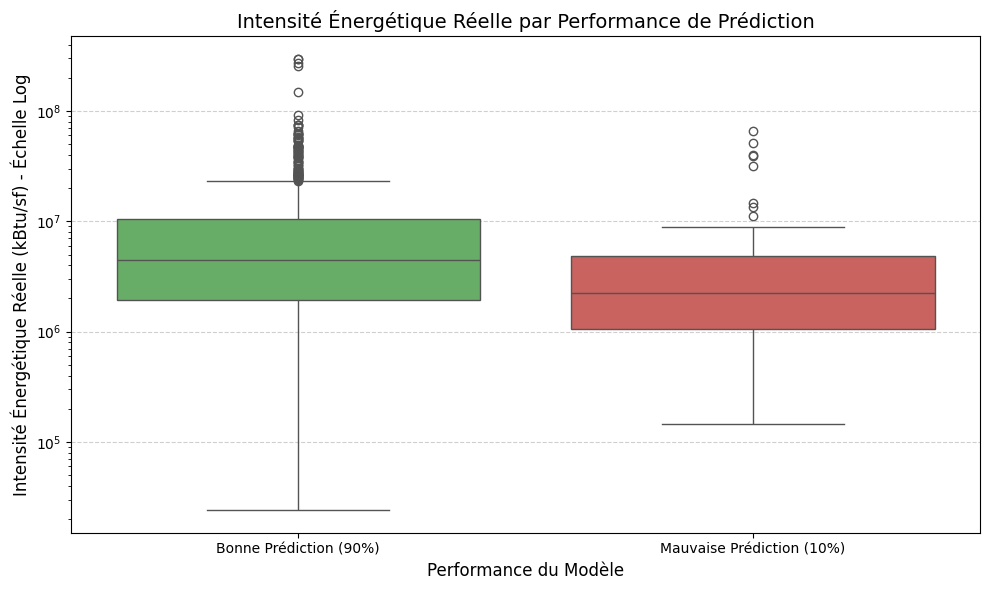

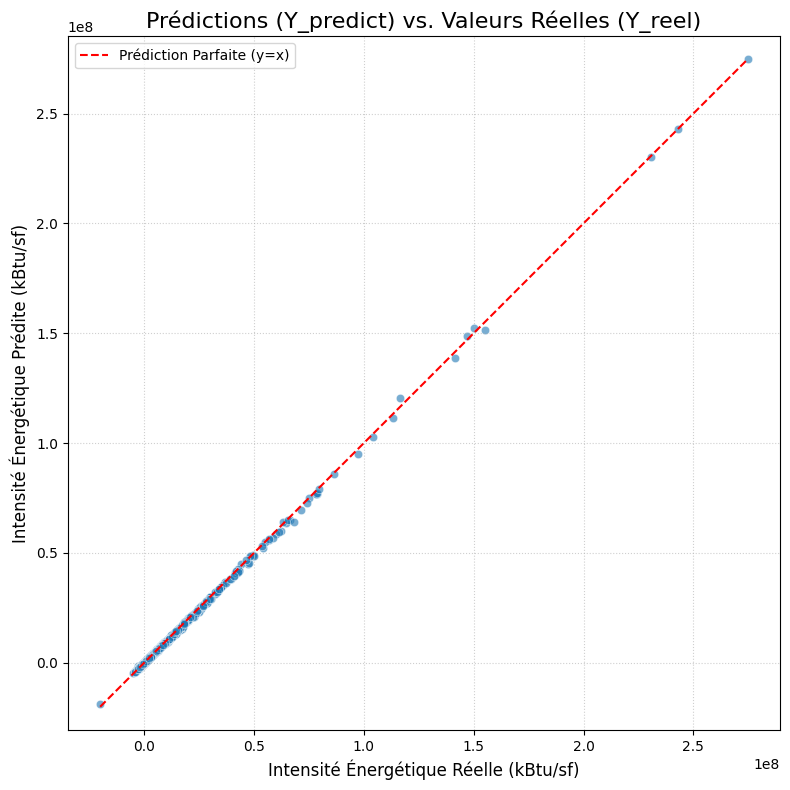

In [163]:
# Les données sont dans df_resultats.
y_reel = df_resultats['y_reel']
y_prediction = df_resultats['y_predict']

plt.figure(figsize=(8, 8))

# 1. Tracé des points de prédiction (Scatter Plot)
sns.scatterplot(
    x=y_reel, 
    y=y_prediction, 
    alpha=0.6, # Transparence pour voir la densité
    edgecolor='w'
)

# 2. Ajout de la Droite Parfaite (y=x)
# Nous traçons une droite allant de la valeur minimale à la valeur maximale
# des données. Cela représente la prédiction idéale.
max_val = max(y_reel.max(), y_prediction.max())
min_val = min(y_reel.min(), y_prediction.min())

# Créer une ligne de référence
plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color='red', 
    linestyle='--', 
    label='Prédiction Parfaite (y=x)'
)

# 3. Paramètres du graphique
plt.title("Prédictions (Y_predict) vs. Valeurs Réelles (Y_reel)", fontsize=16)
plt.xlabel("Intensité Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Intensité Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal') # Pour s'assurer que les échelles X et Y sont les mêmes
plt.tight_layout()
plt.show()

#### Idées de feature Engineering

 - % PrimaryUseType
 - % SecondUseType
 - LargestPropertyUseTypeGFA/ Nombre de bâtiments
 - PropertyGFABuilding/ Nb of building
 - PropertyGFABuilding/ Nb of floor
 - Regarder si PrimaryPropertyType est un bâtiment à haute consommation ( hopital, Data Center)
 - Regarder l'année de construction du bâtiment * Surface : un vieux & grand bâtiment peut consommer + qu'un vieux petit bâtiment
 - Regarder le nb d'usage unique dans "ListOfAllPropertyUseTypes' pour voir si il ya bcp de diversité dans l'usage des bâtiments

In [132]:
# CODE COMPARAISON DES MODELES

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [133]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE